The purpose of this notebook is to make outcome predictions.

Future usage of the numerically encoded dataset may need to consider dropping a reference category so this reference case is encoded when all values are zero.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
# # the "1" means: always reload modules marked with "%aimport"
%autoreload 2

from __future__ import absolute_import, division, print_function
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
# from tqdm import tqdm
# import warnings

# sns.set_context("poster", font_scale=0.9)
sns.set_context("notebook", font_scale=1.0)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# add the data functions to the path
src_data_dir = os.path.join(os.getcwd(), os.pardir, 'src/data')
sys.path.append(src_data_dir)

# functions to load the data
import homeless_dataset as hd

In [2]:
# my gist from https://gist.github.com/warmlogic/afaf1d2b1ce90927d14f008571b6f6f0
import classify_utils as cu

In [3]:
datadir_raw = os.path.join(os.getenv('HOME'), 'Dropbox', 'C4SF-datasci-homeless', 'raw')
datadir_proc = os.path.join(os.getenv('HOME'), 'Dropbox', 'C4SF-datasci-homeless', 'processed')

In [4]:
# load the data

df_features = pd.read_csv(os.path.join(datadir_proc, '2017-01-22_homeless_summary_categorical_string.csv'), header=0, index_col=0)

In [5]:
df_features.describe()

chronic_homeless  client_age_at_entry  continuously_homeless_one_year  \
count      11362.000000         11362.000000                    11362.000000   
mean           0.059849            33.622250                        0.185443   
std            0.237217            20.246602                        0.388673   
min            0.000000             0.000000                        0.000000   
25%            0.000000            16.000000                        0.000000   
50%            0.000000            34.000000                        0.000000   
75%            0.000000            51.000000                        0.000000   
max            1.000000           101.000000                        1.000000   

       days_enrolled  days_to_residential_move_in  disabling_condition  \
count   11362.000000                   747.000000         11362.000000   
mean      207.853459                    72.552878             0.390512   
std       330.189494                    81.557515             0.487887   
min         0.000000                     1.000000             0.000000   
25%        26.000000                    16.000000             0.000000   
50%        96.000000                    48.000000             0.000000   
75%       258.000000                    97.000000             1.000000   
max      5040.000000                   730.000000             1.000000   

       domestic_violence_victim  dv_currently_fleeing   enrollments  \
count              11362.000000          11362.000000  11362.000000   
mean                   0.183154              0.001672      5.123130   
std                    0.386810              0.040861     18.586563   
min                    0.000000              0.000000      1.000000   
25%                    0.000000              0.000000      1.000000   
50%                    0.000000              0.000000      2.000000   
75%                    0.000000              0.000000      2.000000   
max                    1.000000              1.000000    577.000000   

       head_of_household  in_permanent_housing  months_ago_dv_occurred  \
count       11362.000000          11362.000000             1910.000000   
mean            0.409347              0.101039               16.102618   
std             0.491735              0.301393                9.192029   
min             0.000000              0.000000                3.000000   
25%             0.000000              0.000000                6.000000   
50%             0.000000              0.000000               24.000000   
75%             1.000000              0.000000               24.000000   
max             1.000000              1.000000               24.000000   

       months_homeless_this_time  times_homeless_past_three_years  \
count                1726.000000                      5202.000000   
mean                    6.976246                         1.346790   
std                     9.969520                         1.122937   
min                     0.000000                         0.000000   
25%                     0.000000                         1.000000   
50%                     1.000000                         1.000000   
75%                    12.000000                         2.000000   
max                    24.000000                         4.000000   

       times_in_permanent_housing   transsexual  veteran_status  \
count                11362.000000  11362.000000    11362.000000   
mean                     0.139236      0.002640        0.192836   
std                      1.042184      0.051319        0.394543   
min                      0.000000      0.000000        0.000000   
25%                      0.000000      0.000000        0.000000   
50%                      0.000000      0.000000        0.000000   
75%                      0.000000      0.000000        0.000000   
max                     68.000000      1.000000        1.000000   

       noncash_benefit_tanfother  noncash_benefit_wic  \
count               11362.000

# Run an overall logistic regression model for everyone together

In [6]:
# drop features that are related to the outcome

outcome = 'in_permanent_housing'
outcome_related = ['days_to_residential_move_in', 'times_in_permanent_housing']
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing']

df_model = df_features.copy()

for col in outcome_related:
    if col in df_model.columns:
        df_model = df_model.drop(col, axis=1)

In [7]:
# fill in any missing values with the median for that column
for col, typ in df_model.dtypes.iteritems():
    if typ != 'object':
        df_model[[col]] = df_model[[col]].apply(lambda x: x.fillna(x.median()))

In [8]:
# drop some rows that make up few enough of certain categories that they cause issues with logistic regression

living_vals_drop = [
    'owned',
    'safehaven',
    'foster',
    'permanenthousing',
    'halfwayhouse',
    'ownedsubsidy',
    'longtermcare',
    'rentalgdptip',
]

df_model = df_model.loc[(df_model['gender'] != 'unknown') &
                        (df_model['housing_status_project_start'] != 'cat3homelessfedstatutes') &
                        (df_model['housing_status_project_start'] != 'cat4fleeingdv') &
                        (df_model['housing_status_project_start'] != 'housed') &
                        df_model['living_situation_before_program_entry'].apply(lambda x: False if x in living_vals_drop else True), :]

In [9]:
outcome = 'in_permanent_housing'

f = """
in_permanent_housing ~ client_age_at_entry 
+ chronic_homeless 
+ domestic_violence_victim 
+ disabling_condition 
+ veteran_status 
+ head_of_household 
+ C(gender) 
+ C(race) 
+ C(ethnicity) 
+ C(project_type_code) 
+ C(housing_status_project_start) 
+ C(living_situation_before_program_entry) 
+ continuously_homeless_one_year 
+ I(days_enrolled / (365.25 / 12))
+ dv_currently_fleeing 
+ enrollments 
+ months_ago_dv_occurred 
+ months_homeless_this_time 
+ times_homeless_past_three_years 
+ transsexual 
+ noncash_benefit_tanfother 
+ noncash_benefit_wic 
+ noncash_benefit_publichousing 
+ noncash_benefit_temprental 
+ noncash_benefit_other 
+ noncash_benefit_tanftransportation 
+ noncash_benefit_tanfchildcare 
+ noncash_benefit_foodstamps 
+ health_insurance_medicaid 
+ health_insurance_statechild 
+ health_insurance_stateadult 
+ health_insurance_veteranadmin 
+ health_insurance_pirvate 
+ health_insurance_employer 
+ health_insurance_medicare 
+ health_insurance_cobra 
+ disability_type_alcohol 
+ disability_type_alcoholdrug 
+ disability_type_chronichealth 
+ disability_type_developmental 
+ disability_type_drug 
+ disability_type_dualdiagnosis 
+ disability_type_hearing 
+ disability_type_hivaids 
+ disability_type_mentalhealth 
+ disability_type_physical 
"""

# these features are causing issues
# + disability_type_substance + disability_type_vision + disability_type_other 

results_log = cu.sm_logit(
    df_model,
    f=f,
    #maxiter=100,
    reg_method = 'l1',
    reg_alpha=0.1,
    )


in_permanent_housing ~ client_age_at_entry 
+ chronic_homeless 
+ domestic_violence_victim 
+ disabling_condition 
+ veteran_status 
+ head_of_household 
+ C(gender) 
+ C(race) 
+ C(ethnicity) 
+ C(project_type_code) 
+ C(housing_status_project_start) 
+ C(living_situation_before_program_entry) 
+ continuously_homeless_one_year 
+ I(days_enrolled / (365.25 / 12))
+ dv_currently_fleeing 
+ enrollments 
+ months_ago_dv_occurred 
+ months_homeless_this_time 
+ times_homeless_past_three_years 
+ transsexual 
+ noncash_benefit_tanfother 
+ noncash_benefit_wic 
+ noncash_benefit_publichousing 
+ noncash_benefit_temprental 
+ noncash_benefit_other 
+ noncash_benefit_tanftransportation 
+ noncash_benefit_tanfchildcare 
+ noncash_benefit_foodstamps 
+ health_insurance_medicaid 
+ health_insurance_statechild 
+ health_insurance_stateadult 
+ health_insurance_veteranadmin 
+ health_insurance_pirvate 
+ health_insurance_employer 
+ health_insurance_medicare 
+ health_insurance_cobra 
+ disability

In [10]:
cu.print_sm_logit_results(results_log);

0                     1                  2          3
0               Model:                 Logit  Pseudo R-squared:      0.487
1  Dependent Variable:  in_permanent_housing               AIC:  3589.1739
2                Date:      2017-01-25 20:31               BIC:  4117.7149
3    No. Observations:                 10304    Log-Likelihood:    -1721.6
4            Df Model:                    72           LL-Null:    -3355.4
5        Df Residuals:                 10231       LLR p-value:     0.0000
6           Converged:                  True             Scale:     1.0000
7      No. Iterations:              987.0000

As feature increases, more likely to be in positive class:


Coef.  Odds Ratio  \
C(project_type_code)[T.rapidrehousing]              5.195651  180.485595   
C(project_type_code)[T.homelessnessprevention]      4.501064   90.112933   
head_of_household                                   1.710804    5.533408   
C(project_type_code)[T.servicesonly]                2.901034   18.192956   
health_insurance_statechild                         2.279319    9.770021   
I(days_enrolled / (365.25 / 12))                    0.043071    1.044012   
health_insurance_medicaid                           0.929285    2.532698   
health_insurance_stateadult                         1.669770    5.310946   
noncash_benefit_publichousing                       1.559495    4.756417   
health_insurance_veteranadmin                       0.826252    2.284739   
C(housing_status_project_start)[T.cat1homeless]     1.132254    3.102641   
C(project_type_code)[T.permanentsupportivehousing]  2.387318   10.884258   
C(housing_status_project_start)[T.unknown]          0.858144    2.358779   
C(living_situation_before_program_entry)[T.rental]  2.093560    8.113749   
C(race)[T.asian]                                    1.107896    3.027980   
months_homeless_this_time                           0.030229    1.030690   
C(living_situation_before_program_entry)[T.rent...  2.060227    7.847752   
C(race)[T.black]                                    0.787606    2.198127   
C(race)[T.white]                                    0.700394    2.014547   
C(living_situation_before_program_entry)[T.rent...  1.712226    5.541282   
C(living_situation_before_program_entry)[T.hotel]   1.637120    5.140345   
continuously_homeless_one_year                      0.357494    1.429742   
C(project_type_code)[T.other]                       1.118530    3.060351   
health_insurance_employer                           0.905943    2.474263   
disability_type_physical                            0.328599    1.389021   

                                                    Std.Err.          z  \
C(project_type_code)[T.rapidrehousing]              0.271686  19.123732   
C(project_type_code)[T.homelessnessprevention]      0.280253  16.060689   
head_of_household                                   0.131269  13.032791   
C(project_type_code)[T.servicesonly]                0.251725  11.524612   
health_insurance_statechild                         0.219876  10.366391   
I(days_enrolled / (365.25 / 12))                    0.005038   8.549546   
health_insurance_medicaid                           0.122684   7.574655   
health_insurance_stateadult                         0.232982   7.166960   
noncash_benefit_publichousing                       0.287464   5.425013   
health_insurance_veteranadmin                       0.168950   4.890507   
C(housing_status_project_start)[T.cat1homeless]     0.252205   4.489419   
C(project_type_code)[T.permanentsupportivehousing]  0.562187   4.246482   
C(housing_status_project_start)[T.unknown]          0.251838   3.407524   
C(living_situation_before_program_entry)[T.rental]  0.637879   3.282062   
C(race)[T.asian]                                    0.352295   3.144794   
months_homeless_this_time                           0.009797   3.085597   
C(living_situation_before_program_entry)[T.rent...  0.681530   3.022945   
C(race)[T.black]                                    0.266986   2.949985   
C(race)[T.white]                                    0.239093   2.929384   
C(living_situation_before_program_entry)[T.rent...  0.667864   2.563733   
C(living_situation_before_program_entry)[T.hotel]   0.642607   2.547623   
continuously_homeless_one_year                      0.149319   2.394162   
C(project_type_code)[T.other]                       0.471393   2.372819   
health_insurance_employer                           0.461495   1.963059   
disability_type_physical                            0.167508   1.961700   

                                                           P>|z|    [0.025  \
C(project_type_code)[T.rapidrehousing]           


As feature increases, less likely to be in positive class:


Coef.   Odds Ratio  Std.Err.          z  \
Intercept                       -9.121856  9153.171052  0.870599 -10.477677   
domestic_violence_victim        -0.872681     2.393318  0.201907  -4.322186   
times_homeless_past_three_years -0.259520     1.296307  0.066534  -3.900576   
health_insurance_cobra          -4.278074    72.101416  1.122560  -3.810999   
disabling_condition             -0.487213     1.627773  0.130694  -3.727886   
noncash_benefit_wic             -1.615884     5.032337  0.435830  -3.707603   
noncash_benefit_foodstamps      -0.395962     1.485813  0.118365  -3.345261   
disability_type_hivaids         -2.454122    11.636211  0.800596  -3.065369   
C(ethnicity)[T.nonlatino]       -0.311759     1.365826  0.111708  -2.790830   
disability_type_drug            -0.942316     2.565917  0.372190  -2.531812   
disability_type_developmental   -0.912555     2.490677  0.416793  -2.189466   
C(gender)[T.male]               -0.227625     1.255614  0.108275  -2.102279   

                                        P>|z|     [0.025    0.975]  
Intercept                        1.093980e-25 -10.828198 -7.415513  
domestic_violence_victim         1.544905e-05  -1.268412 -0.476950  
times_homeless_past_three_years  9.596428e-05  -0.389923 -0.129116  
health_insurance_cobra           1.384065e-04  -6.478250 -2.077897  
disabling_condition              1.930927e-04  -0.743369 -0.231057  
noncash_benefit_wic              2.092304e-04  -2.470095 -0.761673  
noncash_benefit_foodstamps       8.220518e-04  -0.627954 -0.163971  
disability_type_hivaids          2.174018e-03  -4.023261 -0.884983  
C(ethnicity)[T.nonlatino]        5.257312e-03  -0.530704 -0.092815  
disability_type_drug             1.134748e-02  -1.671795 -0.212836  
disability_type_developmental    2.856299e-02  -1.729455 -0.095655  
C(gender)[T.male]                3.552886e-02  -0.439841 -0.015409

# Run separate models for different groups

Use sklearn, with one-hot encoded categorical data

## Groups to predict permanent housing outcome

- veteran_status
- chronic_homeless
- continuously_homeless_one_year
- disabling_condition
- domestic_violence_victim
- gender_female
- gender_male
- ethnicity_latino
- ethnicity_nonlatino


In [11]:
df_features_num = pd.read_csv(os.path.join(datadir_proc, '2017-01-22_homeless_summary_categorical_numeric.csv'), header=0, index_col=0)

In [12]:
# fewer than half a percent (0.5%) of people have these features
member_size_threshold=0.005

if member_size_threshold < 1:
    member_size_threshold = int(np.ceil(df_features_num.shape[0] * member_size_threshold))

cols_to_drop_few = df_features_num.columns[df_features_num.sum() < member_size_threshold].tolist()
print('Dropping these columns due to fewer than {} people having this:\n'.format(member_size_threshold), cols_to_drop_few)
df_features_num = df_features_num.drop(cols_to_drop_few, axis=1)

Dropping these columns due to fewer than 57 people having this:
 ['dv_currently_fleeing', 'gender_unknown', 'housing_status_project_start_cat4fleeingdv', 'living_situation_before_program_entry_halfwayhouse', 'living_situation_before_program_entry_longtermcare', 'living_situation_before_program_entry_ownedsubsidy', 'living_situation_before_program_entry_rentalgdptip', 'transsexual', 'noncash_benefit_temprental', 'health_insurance_cobra', 'disability_type_other', 'disability_type_dualdiagnosis', 'disability_type_substance', 'disability_type_hearing', 'disability_type_vision']


In [13]:
df_features_num.describe()

chronic_homeless  client_age_at_entry  continuously_homeless_one_year  \
count      11362.000000         11362.000000                    11362.000000   
mean           0.059849            33.622250                        0.185443   
std            0.237217            20.246602                        0.388673   
min            0.000000             0.000000                        0.000000   
25%            0.000000            16.000000                        0.000000   
50%            0.000000            34.000000                        0.000000   
75%            0.000000            51.000000                        0.000000   
max            1.000000           101.000000                        1.000000   

       days_enrolled  days_to_residential_move_in  disabling_condition  \
count   11362.000000                   747.000000         11362.000000   
mean      207.853459                    72.552878             0.390512   
std       330.189494                    81.557515             0.487887   
min         0.000000                     1.000000             0.000000   
25%        26.000000                    16.000000             0.000000   
50%        96.000000                    48.000000             0.000000   
75%       258.000000                    97.000000             1.000000   
max      5040.000000                   730.000000             1.000000   

       domestic_violence_victim   enrollments  ethnicity_latino  \
count              11362.000000  11362.000000      11362.000000   
mean                   0.183154      5.123130          0.458282   
std                    0.386810     18.586563          0.498278   
min                    0.000000      1.000000          0.000000   
25%                    0.000000      1.000000          0.000000   
50%                    0.000000      2.000000          0.000000   
75%                    0.000000      2.000000          1.000000   
max                    1.000000    577.000000          1.000000   

       ethnicity_nonlatino  ethnicity_unknown  gender_female   gender_male  \
count         11362.000000       11362.000000   11362.000000  11362.000000   
mean              0.521827           0.019891       0.426685      0.572346   
std               0.499545           0.139631       0.494618      0.494760   
min               0.000000           0.000000       0.000000      0.000000   
25%               0.000000           0.000000       0.000000      0.000000   
50%               1.000000           0.000000       0.000000      1.000000   
75%               1.000000           0.000000       1.000000      1.000000   
max               1.000000           1.000000       1.000000      1.000000   

       head_of_household  housing_status_project_start_atrisk  \
count       11362.000000                         11362.000000   
mean            0.409347                             0.091445   
std             0.491735                             1.094995   
min             0.000000                             0.000000   
25%             0.000000                             0.000000   
50%             0.000000                             0.000000   
75%             1.000000                             0.000000   
max             1.000000                            94.000000   

       housing_status_project_start_cat1homeless  \
count                               11362.000000   
mean                                    4.110720   
std                                    17.805798   
min                                     0.000000   
25%                                     0.000000   
50%                                     1.000000   
75%                                     2.000000   
max                                   577.000000   

       housing_status_project_start_cat2risklosing  \
count                                 11362.000000   
mean                                      0.273543   
std                                       1.394907   
min                                      

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
# outcome = 'in_permanent_housing'
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
#                    #'project_type_code_rapidrehousing',
#                    #'days_enrolled',
#                   ]
# y = df_model_num[outcome].values
# X = df_model_num.drop(outcome_related, axis=1)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# print('train', X_train.shape)
# print('test', X_test.shape)

In [16]:
def predict_group(df_features_num, col, cols_to_drop,
                  val_to_keep=None,
                  test_size=0.33,
                  member_size_threshold=0.01,
                  print_n_features=20,
                  ):
    if val_to_keep is None:
        val_to_keep = 1
    
    print('\n{} = {}'.format(col, val_to_keep))
    
    #     # these columns have very few people
    #     cols_to_drop_few = [
    #         'gender_unknown',
    #         'housing_status_project_start_cat3homelessfedstatutes',
    #         'housing_status_project_start_cat4fleeingdv',
    #         'housing_status_project_start_housed',
    #         'living_situation_before_program_entry_owned',
    #         'living_situation_before_program_entry_safehaven',
    #         'living_situation_before_program_entry_foster',
    #         'living_situation_before_program_entry_permanenthousing',
    #         'living_situation_before_program_entry_halfwayhouse',
    #         'living_situation_before_program_entry_ownedsubsidy',
    #         'living_situation_before_program_entry_longtermcare',
    #         'living_situation_before_program_entry_rentalgdptip',
    #     ]

    df_model_num = df_features_num.copy()
    
    # df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)
    
    # fill in any missing values with the median for that column
    df_model_num = df_model_num.apply(lambda x: x.fillna(x.median()),axis=0)

    # df_model_num.describe()
    
    df_model_num = df_model_num.loc[df_model_num[col] == val_to_keep, :]
    df_model_num = df_model_num.drop(cols_to_drop, axis=1)
    
    if member_size_threshold < 1:
        member_size_threshold = int(np.ceil(df_model_num.shape[0] * member_size_threshold))
    
    # drop columns where fewer than member_size_threshold have this
    cols_to_drop_few = df_model_num.columns[df_model_num.sum() < member_size_threshold].tolist()
    print('\nDropping these columns due to fewer than {} people having this:\n'.format(member_size_threshold), cols_to_drop_few)
    df_model_num = df_model_num.drop(cols_to_drop_few, axis=1)

    outcome = 'in_permanent_housing'
    outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing',
                       #'project_type_code_rapidrehousing',
                       #'days_enrolled',
                      ]
    y = df_model_num[outcome].values
    X = df_model_num.drop(outcome_related, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    
    print('')
    print('train', X_train.shape)
    print('test', X_test.shape)
    
    print('\n{} = {}'.format(col, val_to_keep))
    results, myAuc, precision, recall, f1, myLR = cu.classify(X_train, X_test,
                                                              y_train, y_test,
                                                              'lr',
                                                              print_n_features=print_n_features);
    return (results, myLR, y)

In [17]:
def collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep=None):
    if val_to_keep is not None:
        col = '{}_{}'.format(col, val_to_keep)
    results['odds'] = results['odds'] * results['coef'].apply(lambda x: np.sign(x))
    coef_df = odds_df.merge(results[['coef']].rename(columns={'coef': col}), how='left', left_index=True, right_index=True,)
    odds_df = odds_df.merge(results[['odds']].rename(columns={'odds': col}), how='left', left_index=True, right_index=True,)
    stat_df.loc[col, 'n'] = int(len(y))
    stat_df.loc[col, 'n_perm_housing'] = int(np.sum(y))
    stat_df.loc[col, 'prop_perm_housing'] = np.sum(y) / len(y)
    return (coef_df, odds_df, stat_df)

In [18]:
coef_df = pd.DataFrame(index=df_features_num.columns)
odds_df = pd.DataFrame(index=df_features_num.columns)
stat_df = pd.DataFrame()


gender_female = 1

Dropping these columns due to fewer than 49 people having this:
 ['living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'health_insurance_pirvate', 'health_insurance_employer', 'disability_type_hivaids']

train (3248, 71)
test (1600, 71)

gender_female = 1

AUC: 0.87495
Precision: 0.3913
Recall: 0.1698
F1 score: 0.2368

Confusion Matrix
Prediction     0   1   All
Truth                     
0           1466  28  1494
1             88  18   106
All         1554  46  1600

Percent of outcomes classified
Prediction          0          1
Truth                           
0           94.337194  60.869565
1            5.662806  39.130435

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_statechild                         1.989969  7.315308
health_insurance_stateadult                         1.883397  6.575805
project_type_code_homelessnessprevention      

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


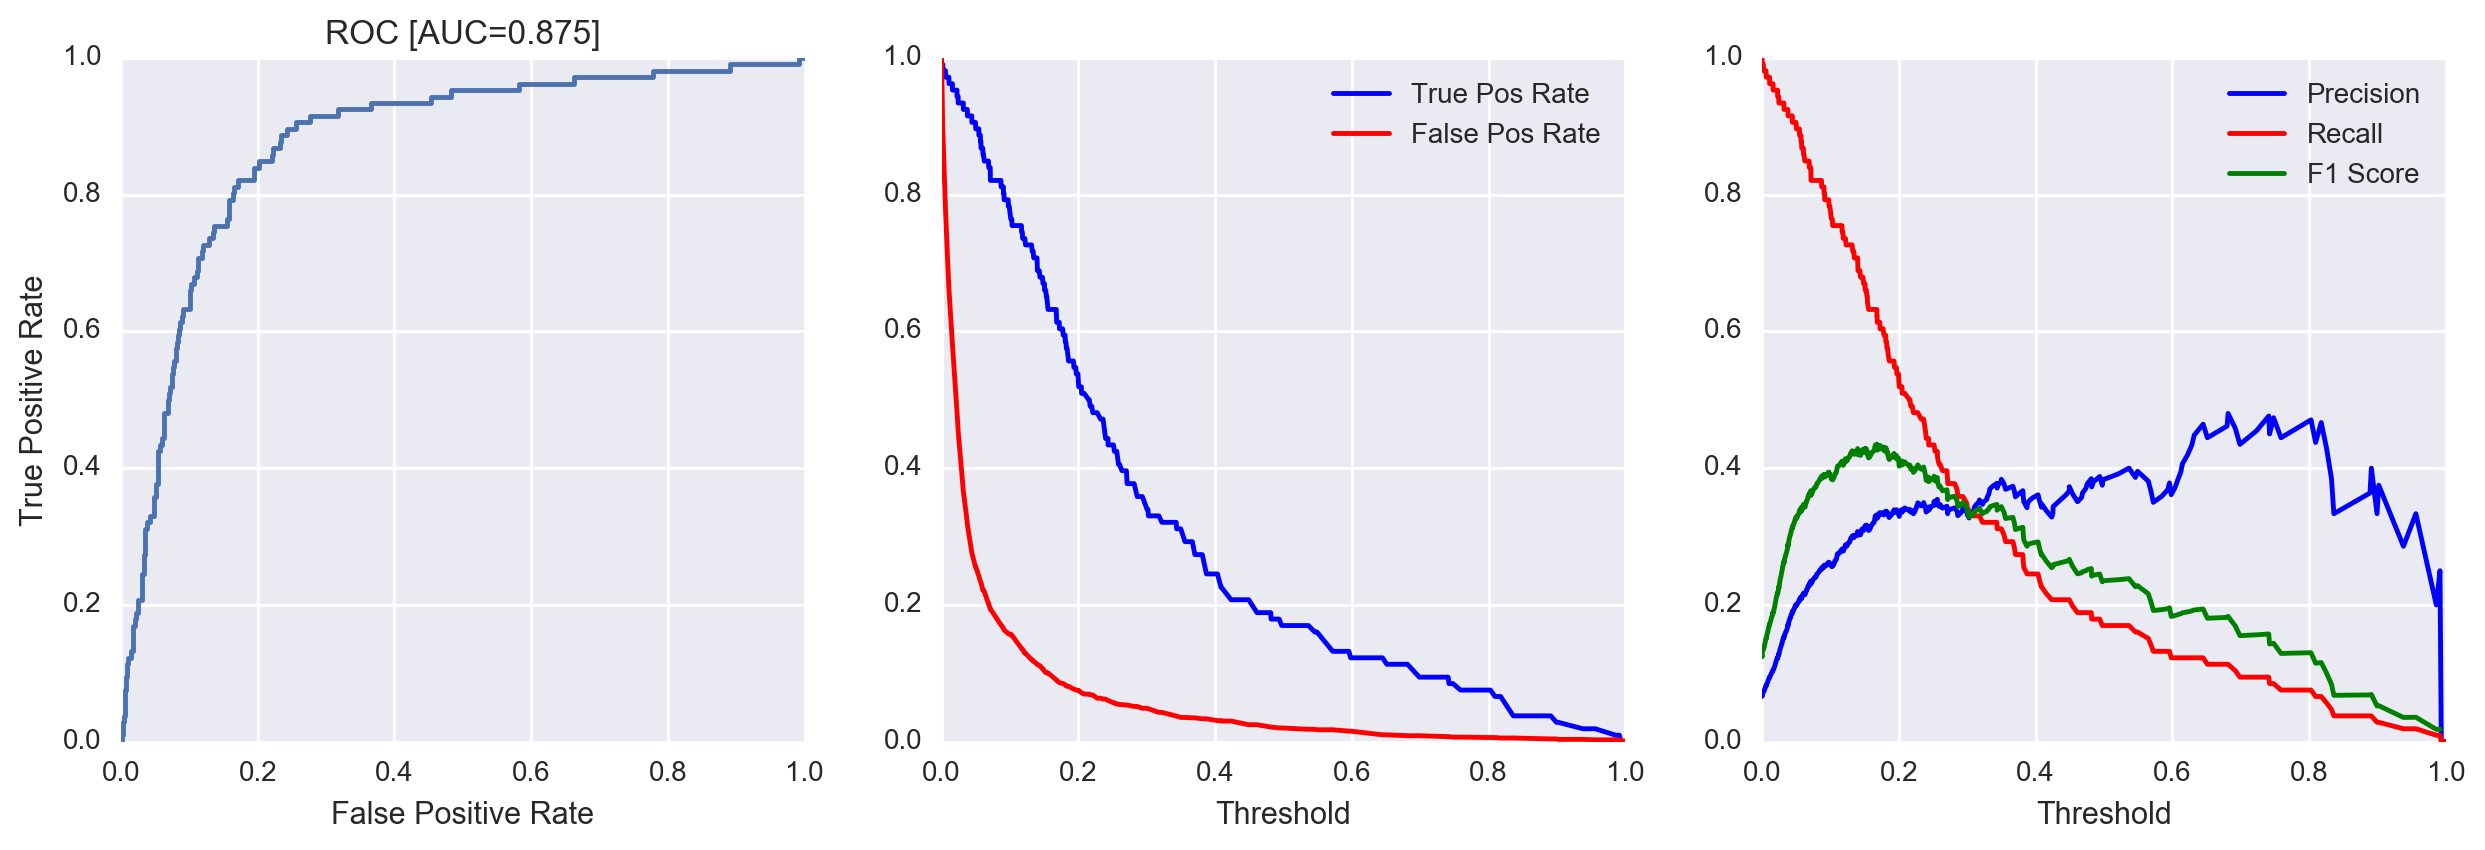

In [19]:
col = 'gender_female'
cols_to_drop = [col, 'gender_male']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


gender_male = 1

Dropping these columns due to fewer than 66 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_permanenthousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (4357, 68)
test (2146, 68)

gender_male = 1

AUC: 0.92519
Precision: 0.7128
Recall: 0.4873
F1 score: 0.5788

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1817   54  1871
1            141  134   275
All         1958  188  2146

Percent of outcomes classified
Prediction          0          1
Truth                           
0           92.798774  28.723404
1            7.201226  71.276596

As feature increases, more likely to be in positive class:
                                                       coef      odds
health_insurance_statechild   

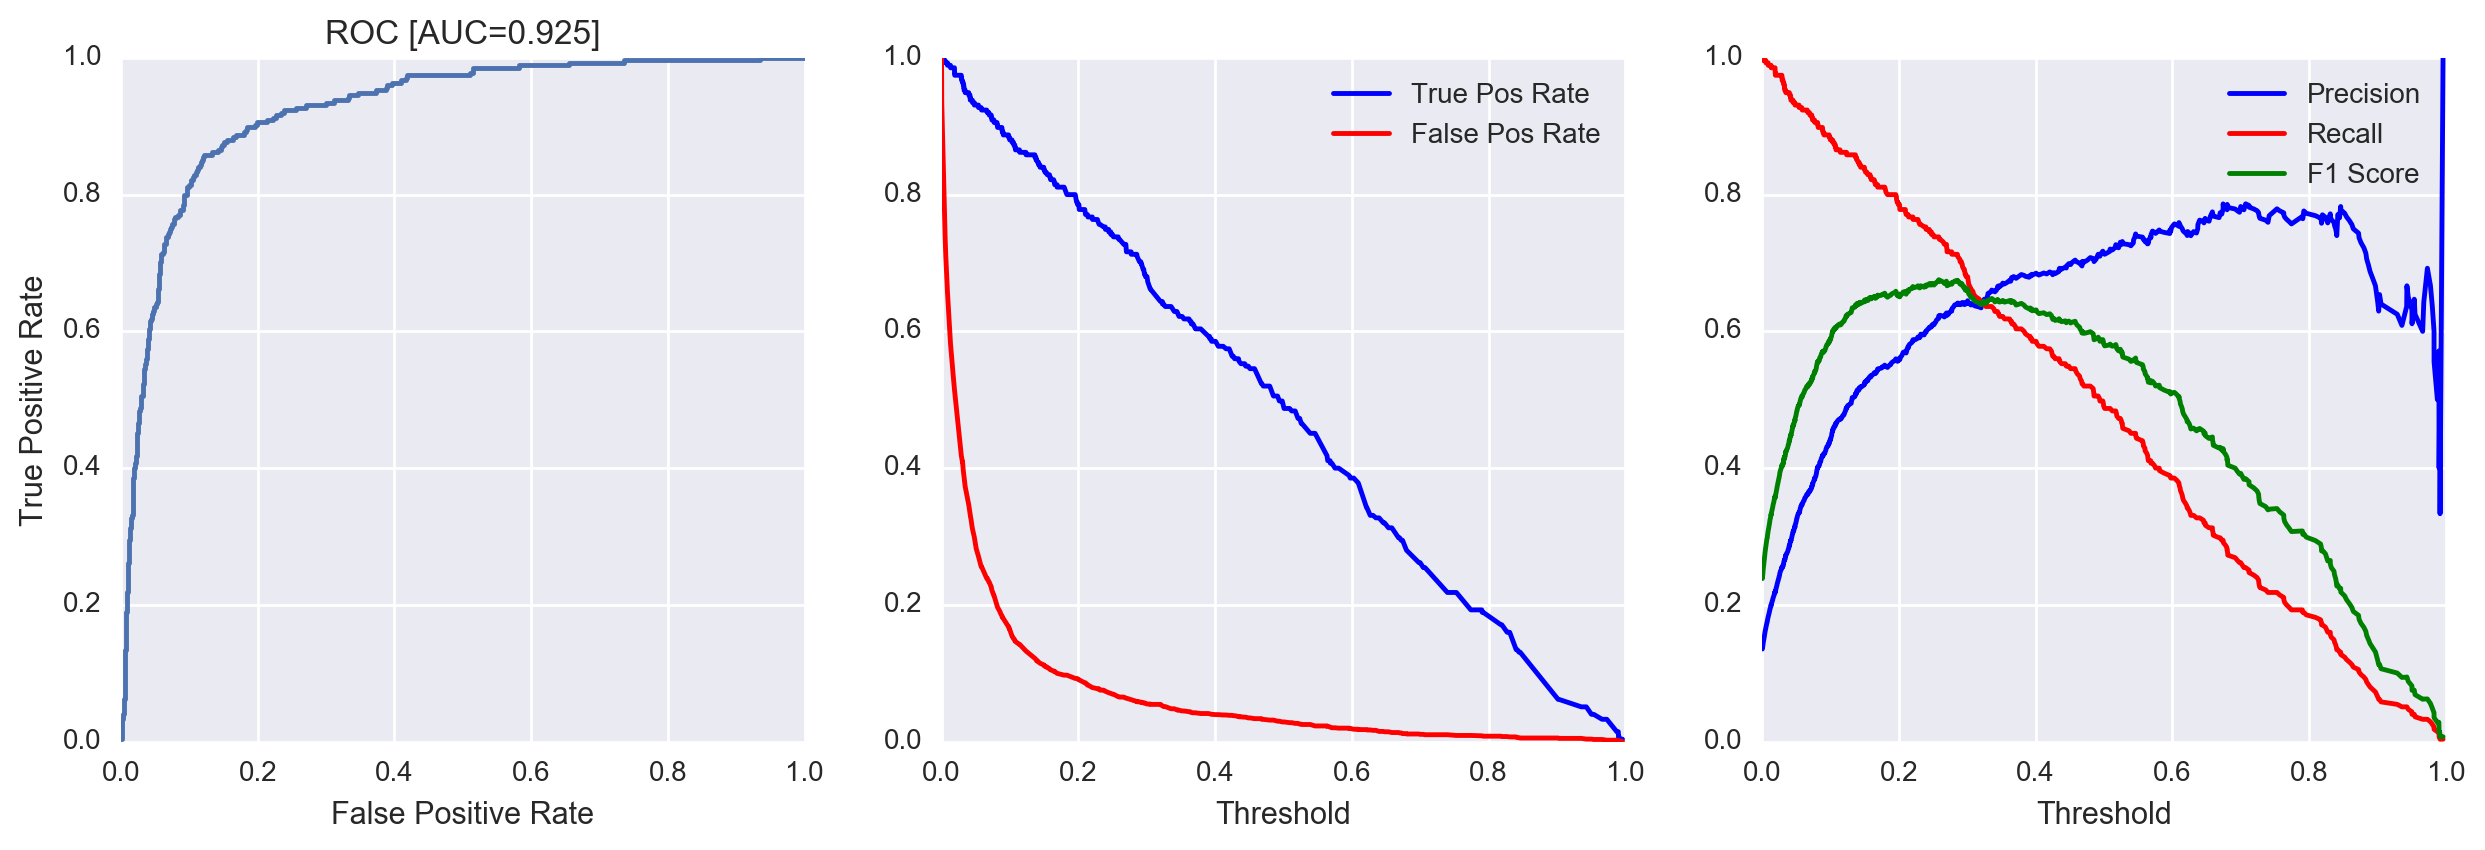

In [20]:
col = 'gender_male'
cols_to_drop = [col, 'gender_female']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


veteran_status = 1

Dropping these columns due to fewer than 22 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'project_type_code_permanentsupportivehousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer', 'health_insurance_statechild', 'disability_type_hivaids']

train (1467, 65)
test (724, 65)

veteran_status = 1

AUC: 0.91256
Precision: 0.6932
Recall: 0.8208
F1 score: 0.7516

Confusion Matrix
Prediction    0    1  All
Truth                    
0           435   77  512
1            38  174  212
All         473  251  724

Percent of outcomes classified
Prediction          0          1
Truth                           
0           91.966173  30.677291
1            8.033827  69.322709

As feature 

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


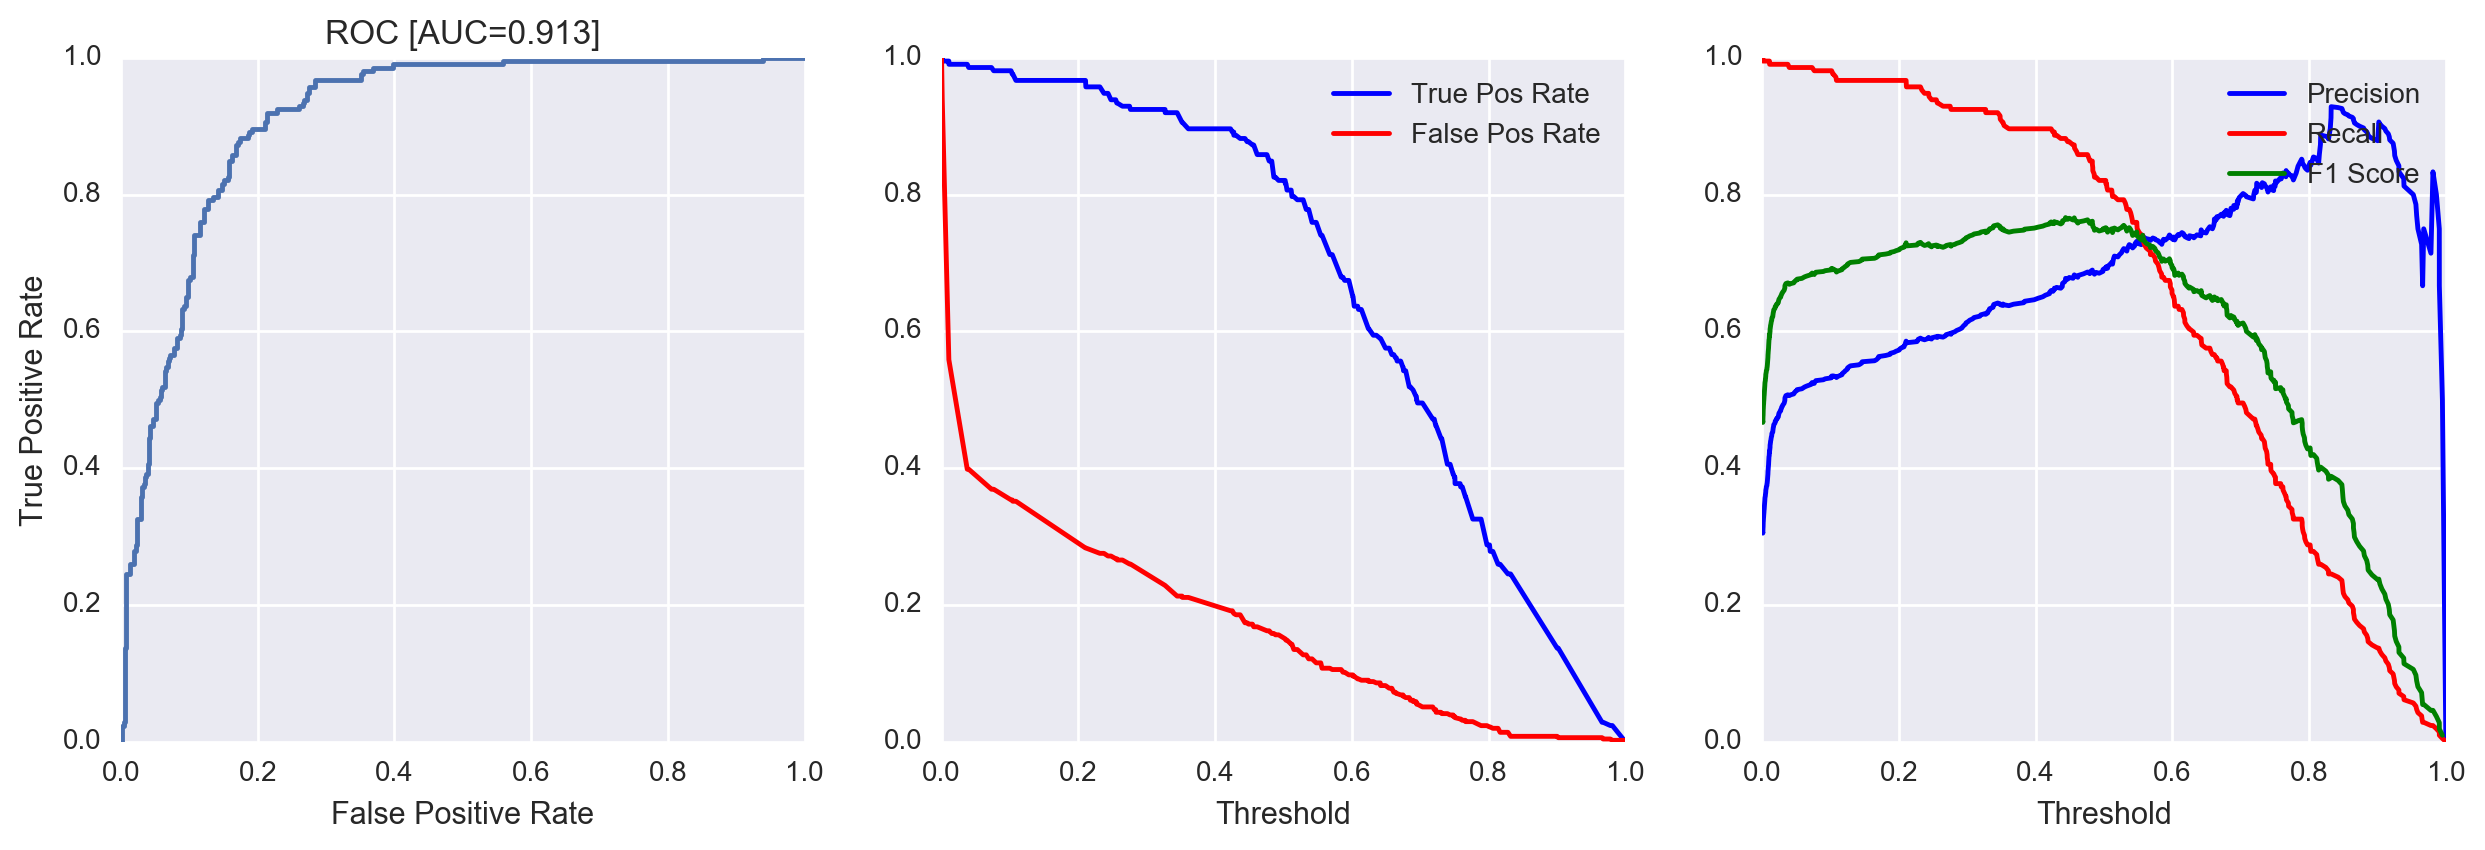

In [21]:
col = 'veteran_status'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


veteran_status = 0

Dropping these columns due to fewer than 92 people having this:
 ['living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'noncash_benefit_publichousing', 'health_insurance_pirvate', 'health_insurance_employer', 'health_insurance_veteranadmin']

train (6144, 69)
test (3027, 69)

veteran_status = 0

AUC: 0.91235
Precision: 0.5714
Recall: 0.1463
F1 score: 0.2330

Confusion Matrix
Prediction     0   1   All
Truth                     
0           2845  18  2863
1            140  24   164
All         2985  42  3027

Percent of outcomes classified
Prediction          0          1
Truth                           
0           95.309883  42.857143
1            4.690117  57.142857

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_stateadult                         2.137071  8.474583
proje

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


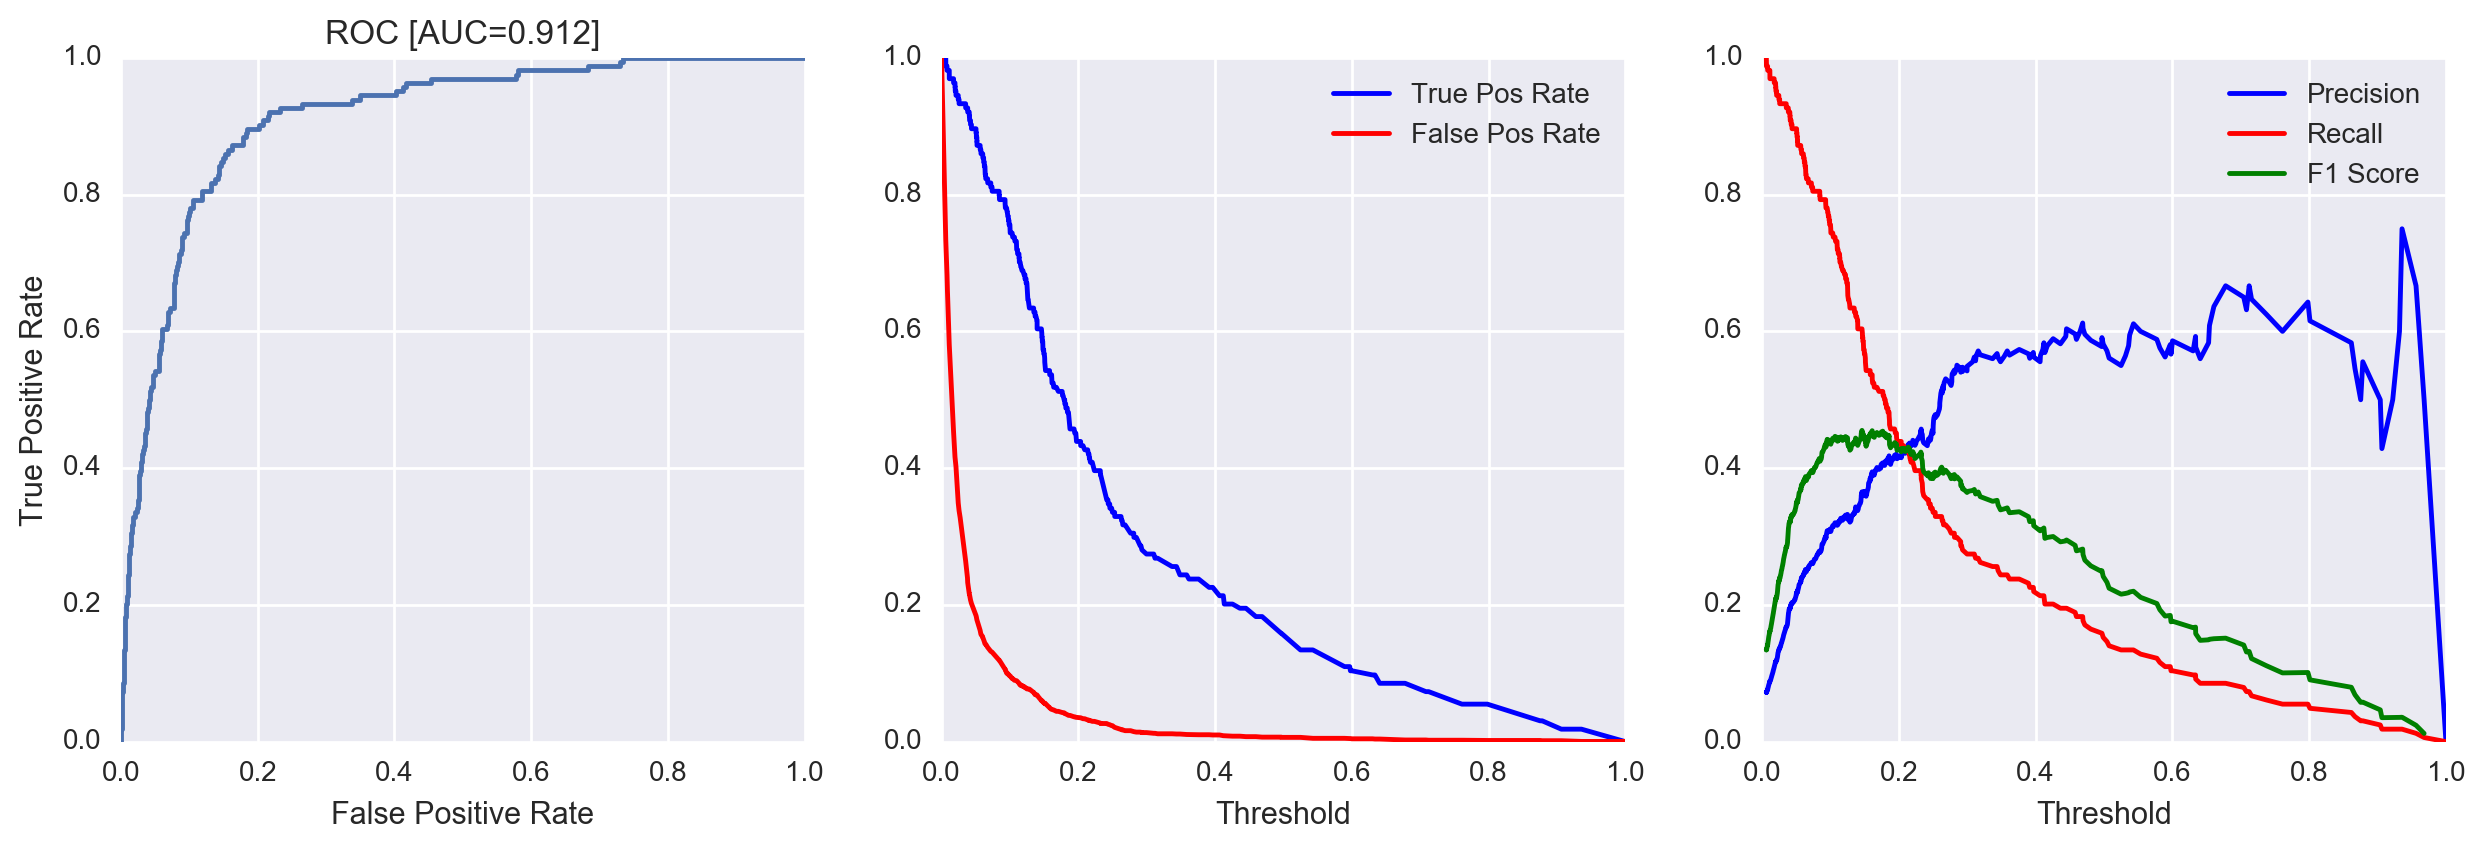

In [22]:
col = 'veteran_status'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


ethnicity_latino = 1

Dropping these columns due to fewer than 53 people having this:
 ['ethnicity_unknown', 'housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_hospitalpsych', 'race_asian', 'race_pacificisl', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'noncash_benefit_publichousing', 'health_insurance_pirvate', 'health_insurance_employer']

train (3488, 64)
test (1719, 64)

ethnicity_latino = 1

AUC: 0.92487
Precision: 0.6885
Recall: 0.3000
F1 score: 0.4179

Confusion Matrix
Prediction     0   1   All
Truth                     
0           1560  19  1579
1             98  42   140
All         1658  61  1719

Percent of outcomes classified
Prediction          0          1
Truth                           
0           94.089264  31.147541
1            5.910736  68.852459

As feature increases, more likely to be in positive class:
           

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


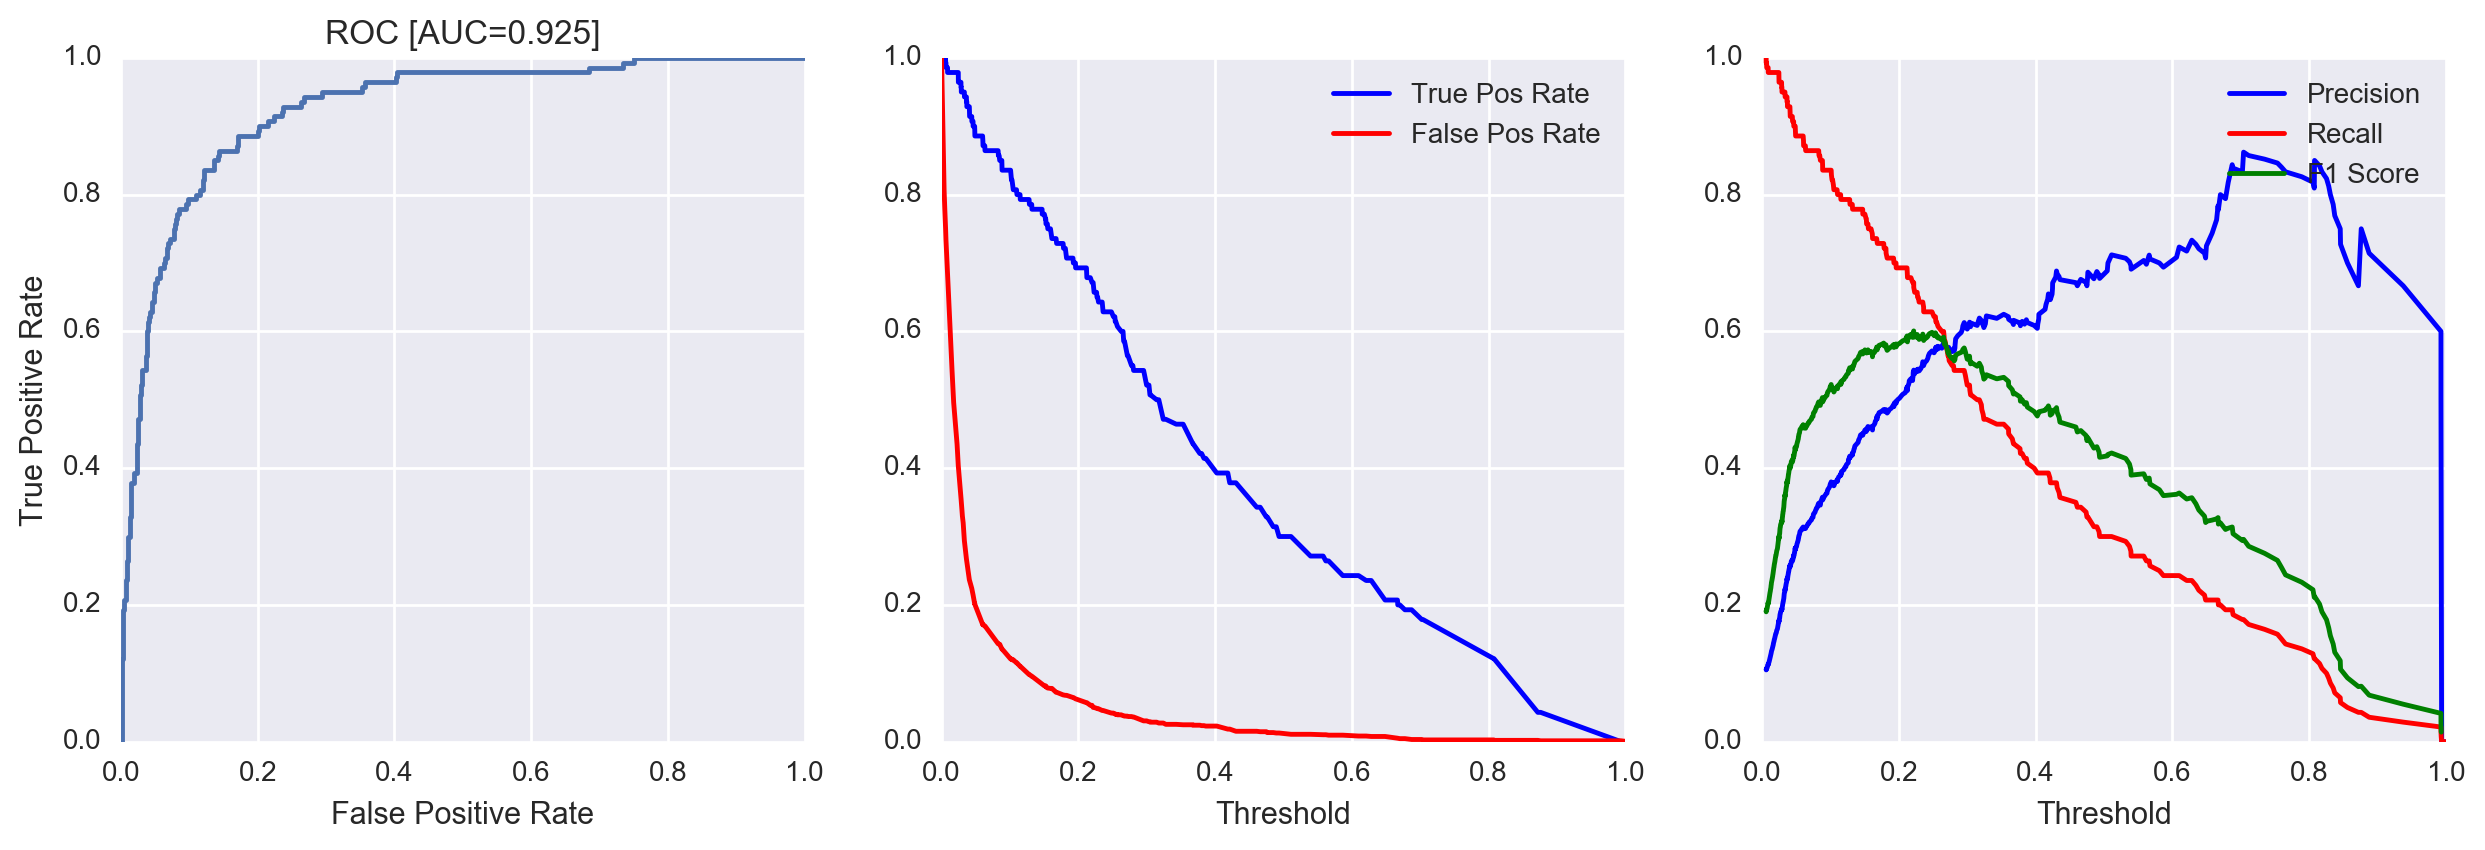

In [23]:
col = 'ethnicity_latino'
cols_to_drop = [col, 'ethnicity_nonlatino']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


ethnicity_nonlatino = 1

Dropping these columns due to fewer than 60 people having this:
 ['ethnicity_unknown', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'race_unknown', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation']

train (3972, 68)
test (1957, 68)

ethnicity_nonlatino = 1

AUC: 0.91469
Precision: 0.6647
Recall: 0.4675
F1 score: 0.5489

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1653   58  1711
1            131  115   246
All         1784  173  1957

Percent of outcomes classified
Prediction          0          1
Truth                           
0           92.656951  33.526012
1            7.343049  66.473988

As feature increases, more likely to be in positive class:
                                                      coef      odds
project_type_code_rapidrehousing            

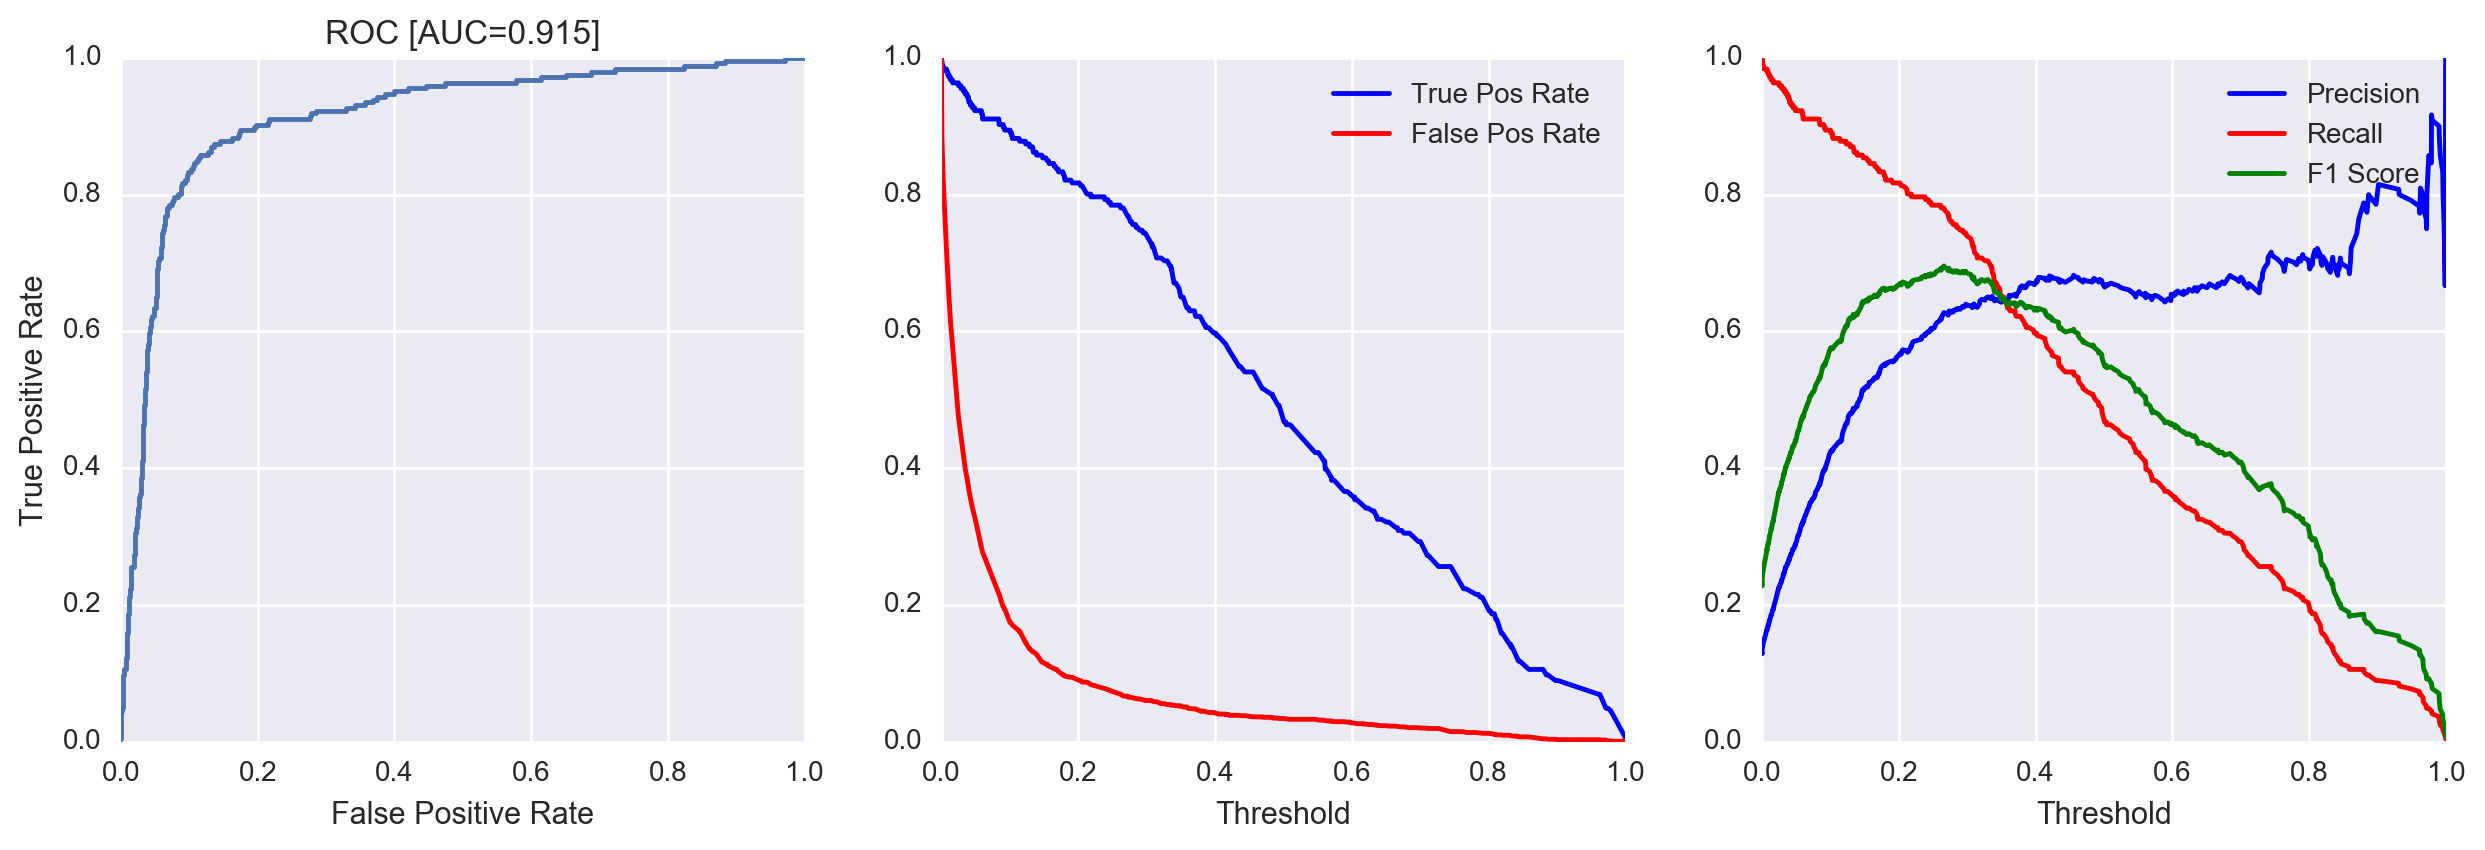

In [24]:
col = 'ethnicity_nonlatino'
cols_to_drop = [col, 'ethnicity_latino']

val_to_keep = None

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


chronic_homeless = 1

Dropping these columns due to fewer than 7 people having this:
 ['living_situation_before_program_entry_foster', 'living_situation_before_program_entry_owned', 'living_situation_before_program_entry_permanenthousing', 'living_situation_before_program_entry_rentalother', 'noncash_benefit_tanfchildcare', 'health_insurance_employer', 'health_insurance_statechild']

train (455, 70)
test (225, 70)

chronic_homeless = 1

AUC: 0.91220
Precision: 0.5385
Recall: 0.6774
F1 score: 0.6000

Confusion Matrix
Prediction    0   1  All
Truth                   
0           176  18  194
1            10  21   31
All         186  39  225

Percent of outcomes classified
Prediction          0          1
Truth                           
0           94.623656  46.153846
1            5.376344  53.846154

As feature increases, more likely to be in positive class:
                                                       coef       odds
veteran_status                                     2.7266

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


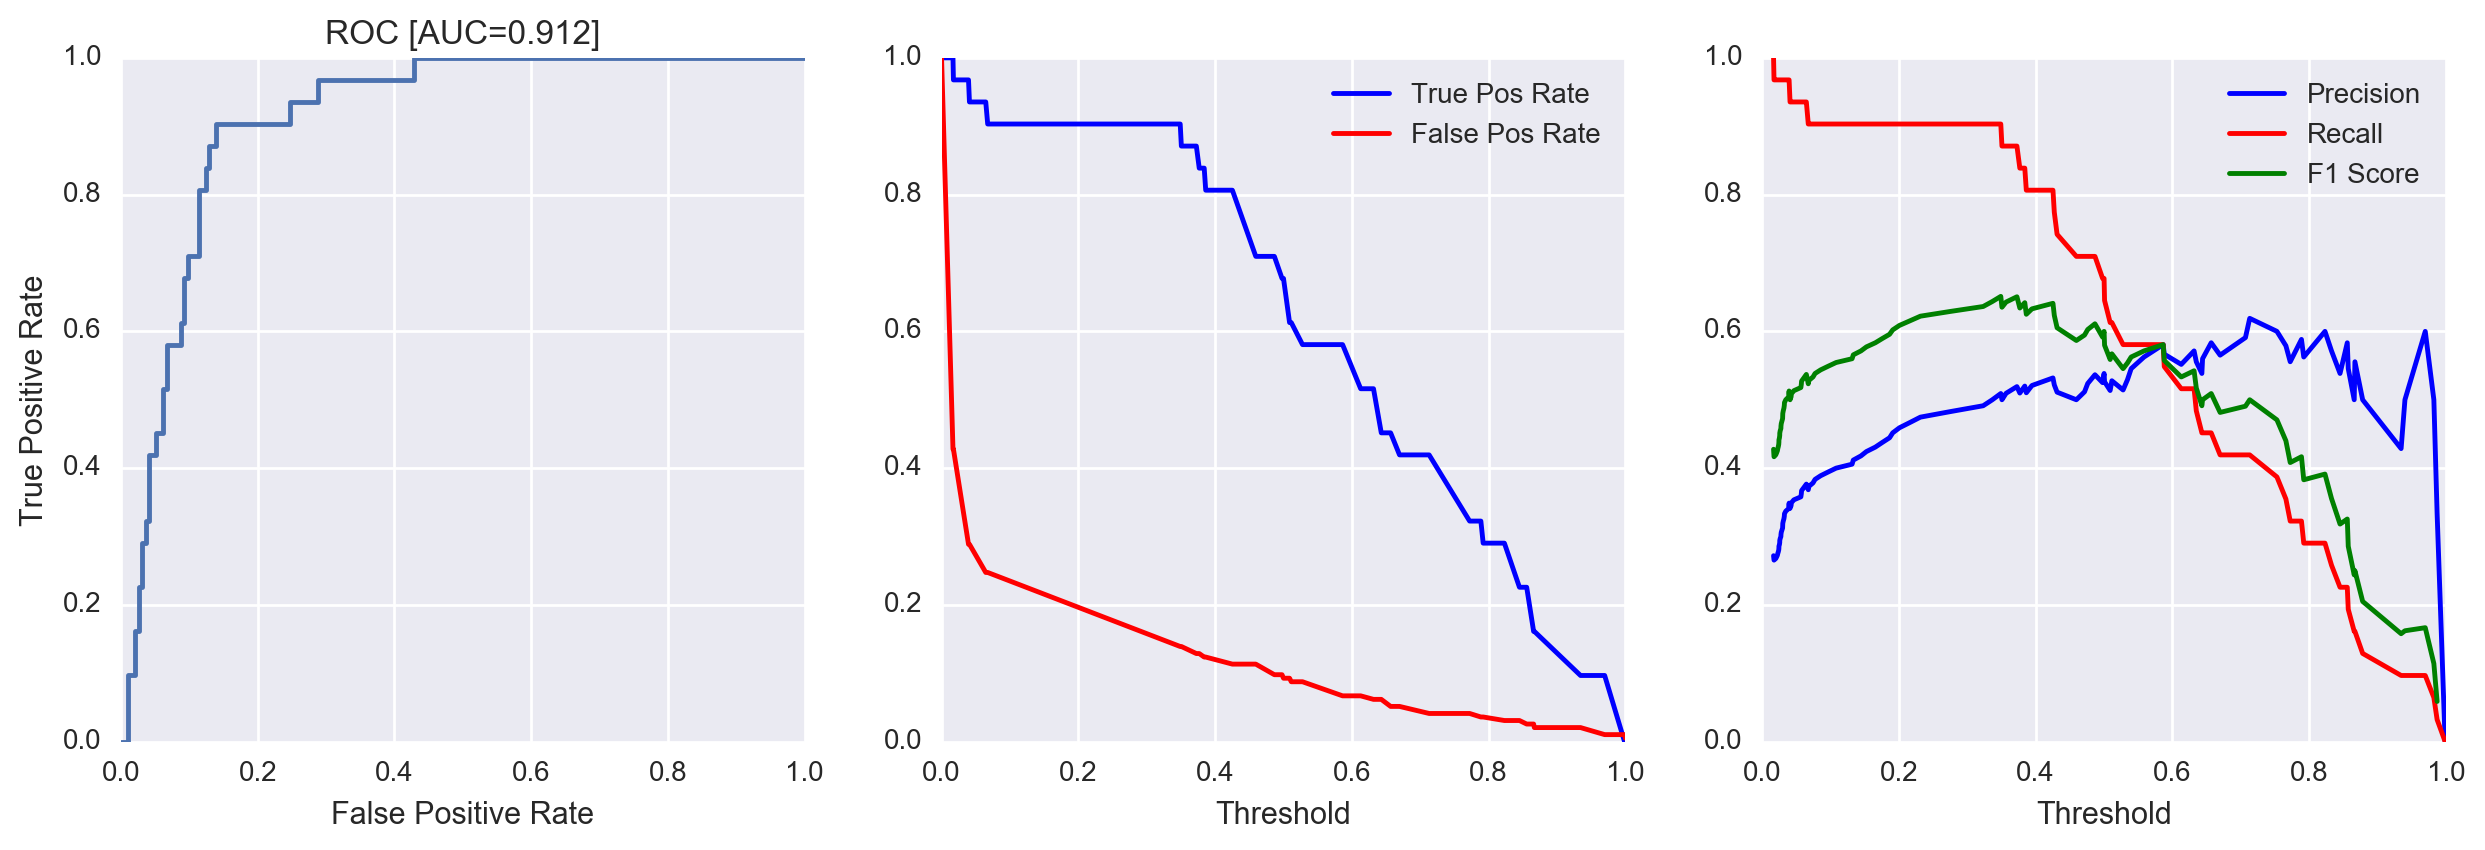

In [25]:
col = 'chronic_homeless'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


chronic_homeless = 0

Dropping these columns due to fewer than 107 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (7156, 70)
test (3526, 70)

chronic_homeless = 0

AUC: 0.91206
Precision: 0.6548
Recall: 0.3839
F1 score: 0.4841

Confusion Matrix
Prediction     0    1   All
Truth                      
0           3122   68  3190
1            207  129   336
All         3329  197  3526

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.781916  34.517766
1            6.218084  65.482234

As feature increases, more likely to be in positive class:
                                                       coef      odds
health_insurance_statechild                        1.744758  5.724519
noncash

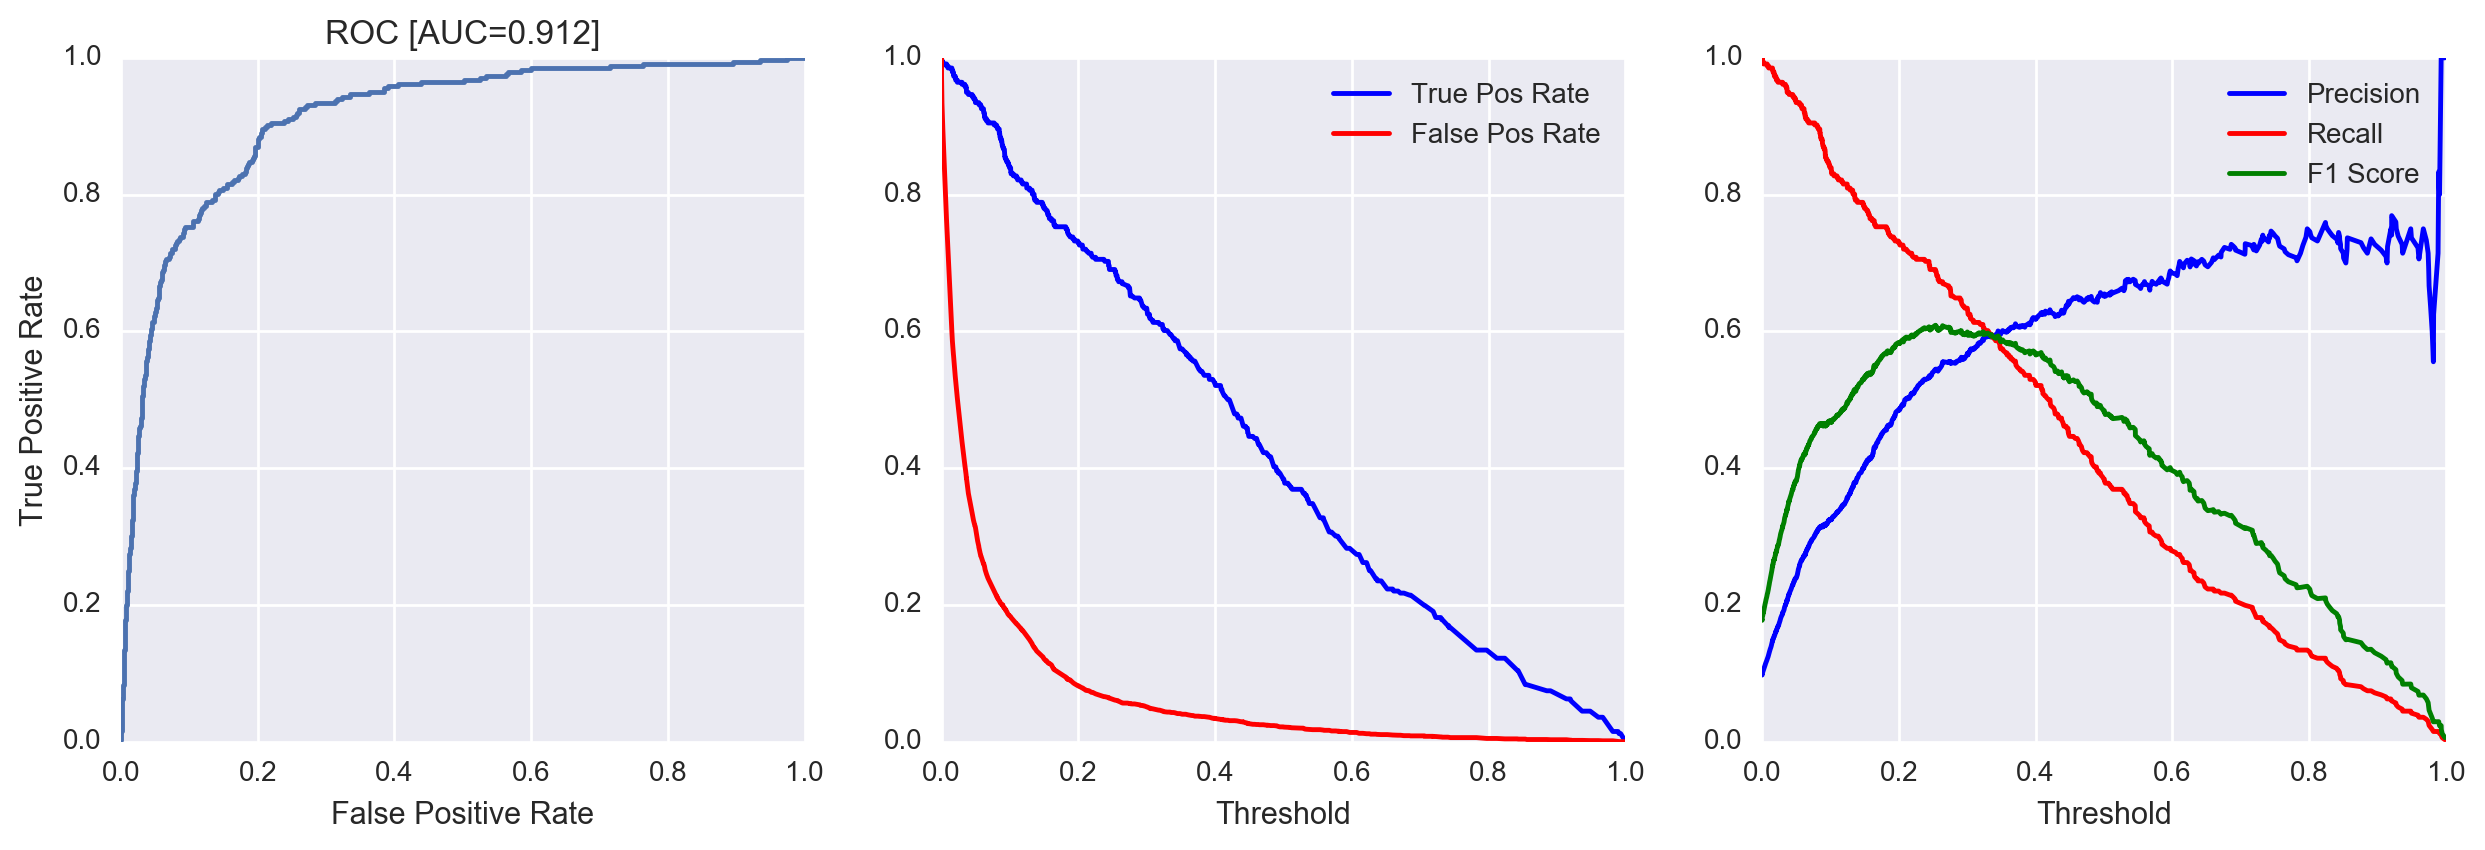

In [26]:
col = 'chronic_homeless'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


continuously_homeless_one_year = 1

Dropping these columns due to fewer than 22 people having this:
 ['living_situation_before_program_entry_owned', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (1411, 71)
test (696, 71)

continuously_homeless_one_year = 1

AUC: 0.90409
Precision: 0.6531
Recall: 0.6275
F1 score: 0.6400

Confusion Matrix
Prediction    0   1  All
Truth                   
0           560  34  594
1            38  64  102
All         598  98  696

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.645485  34.693878
1            6.354515  65.306122

As feature increases, more likely to be in positive class:
                                                        coef      odds
project_type_code_permanentsupportivehousing        2.069579  7.921485
veteran_status                                     

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


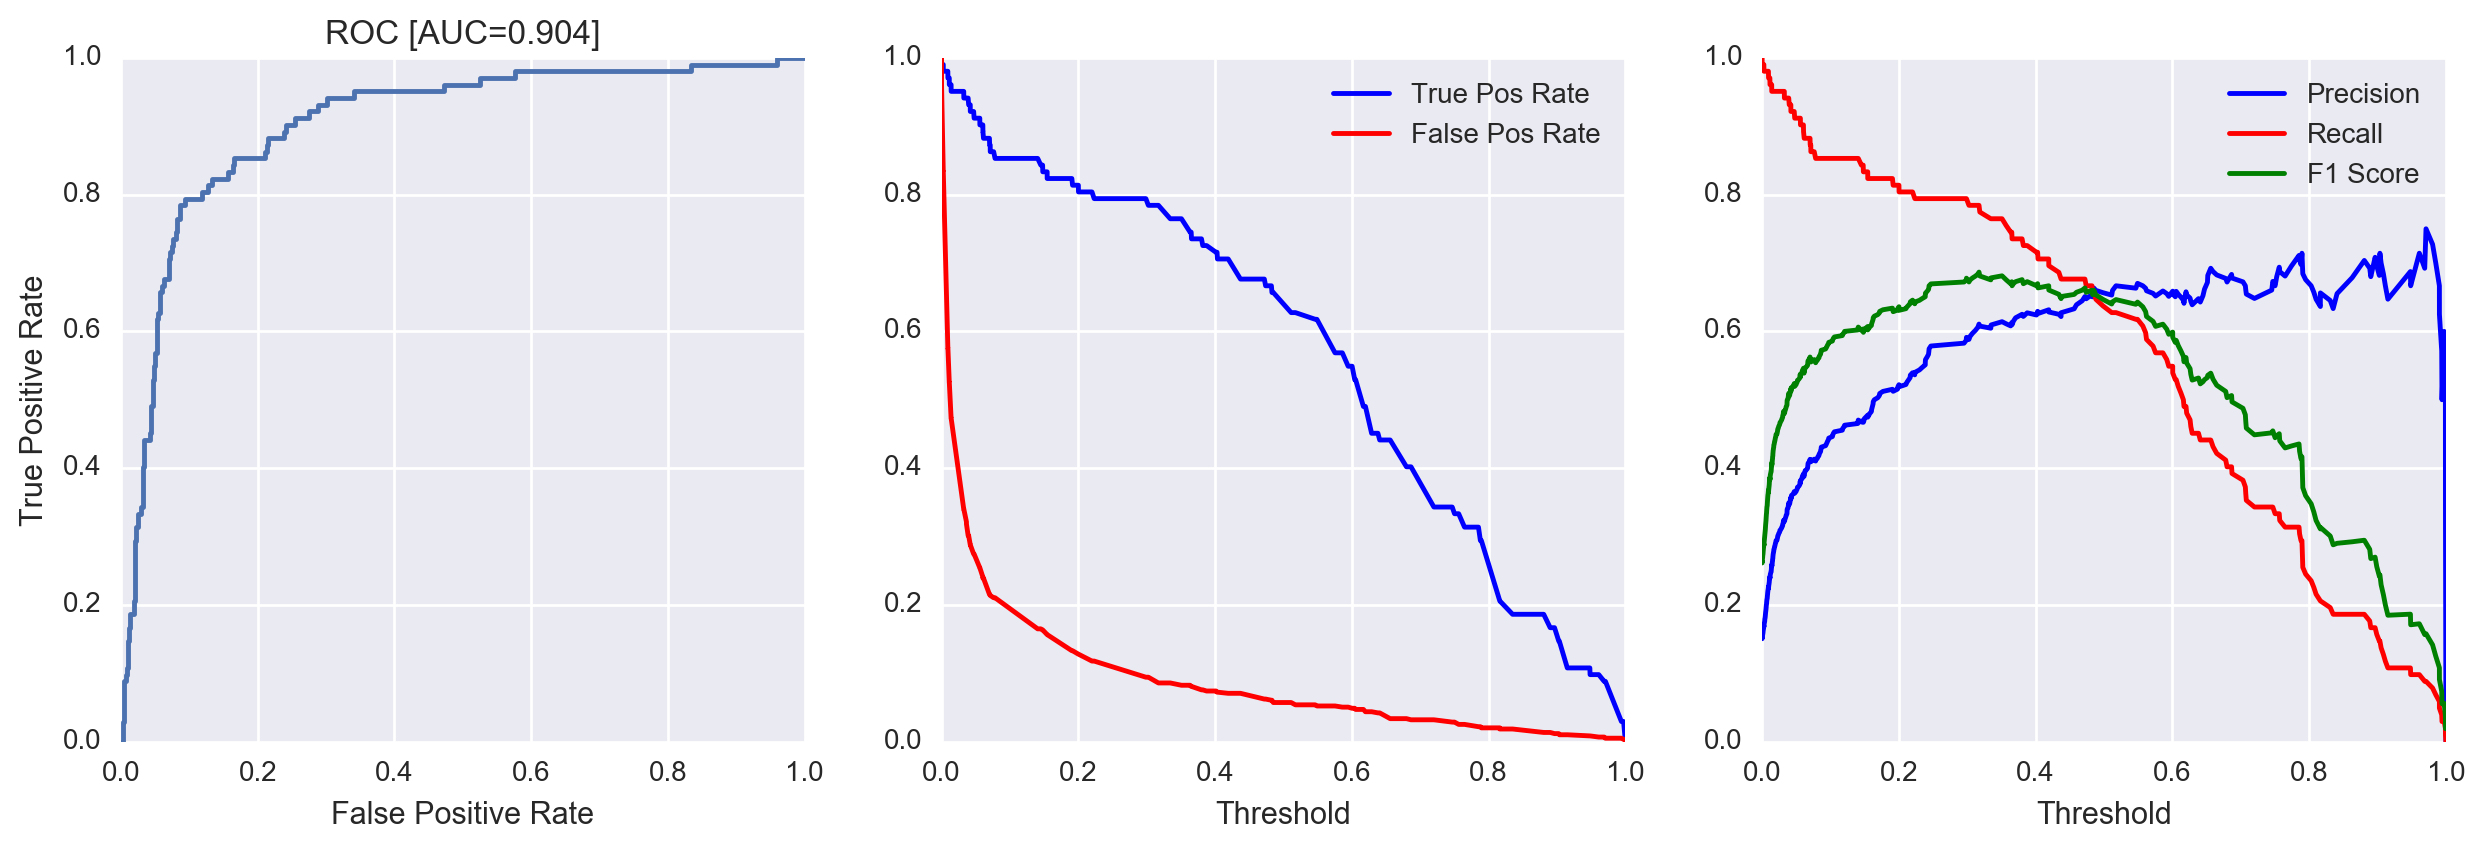

In [27]:
col = 'continuously_homeless_one_year'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


continuously_homeless_one_year = 0

Dropping these columns due to fewer than 93 people having this:
 ['chronic_homeless', 'housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (6200, 69)
test (3055, 69)

continuously_homeless_one_year = 0

AUC: 0.92893
Precision: 0.7214
Recall: 0.3870
F1 score: 0.5037

Confusion Matrix
Prediction     0    1   All
Truth                      
0           2755   39  2794
1            160  101   261
All         2915  140  3055

Percent of outcomes classified
Prediction          0          1
Truth                           
0           94.511149  27.857143
1            5.488851  72.142857

As feature increases, more likely to be in positive class:
                                                        coef      odds
health_insurance_statechild  

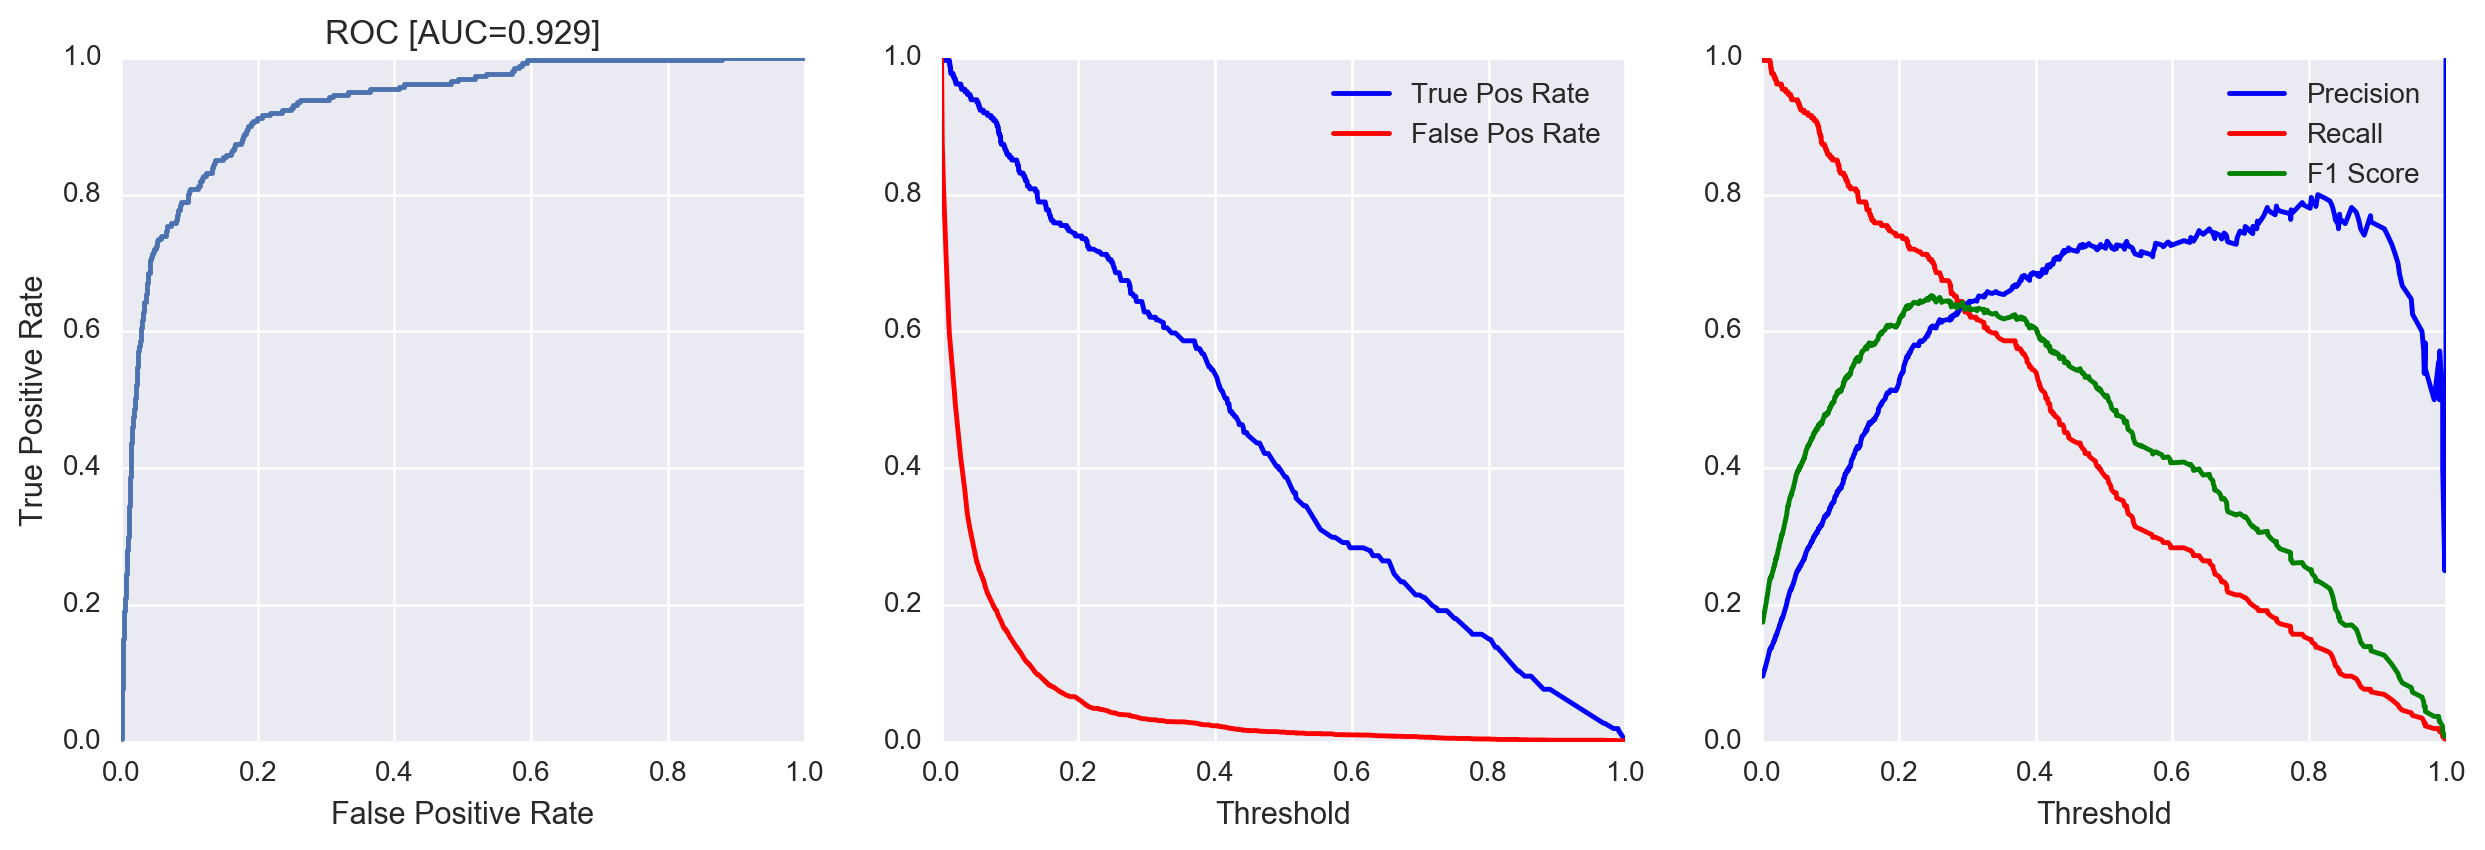

In [28]:
col = 'continuously_homeless_one_year'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


disabling_condition = 1

Dropping these columns due to fewer than 45 people having this:
 ['living_situation_before_program_entry_foster', 'living_situation_before_program_entry_permanenthousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_statechild']

train (2972, 71)
test (1465, 71)

disabling_condition = 1

AUC: 0.92179
Precision: 0.6918
Recall: 0.6395
F1 score: 0.6647

Confusion Matrix
Prediction     0    1   All
Truth                      
0           1244   49  1293
1             62  110   172
All         1306  159  1465

Percent of outcomes classified
Prediction         0         1
Truth                         
0           95.25268  30.81761
1            4.74732  69.18239

As feature increases, more likely to be in positive class:
                                                       coef      odds
head_of_household                                  2.027145  7.592377
veteran_status                    

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


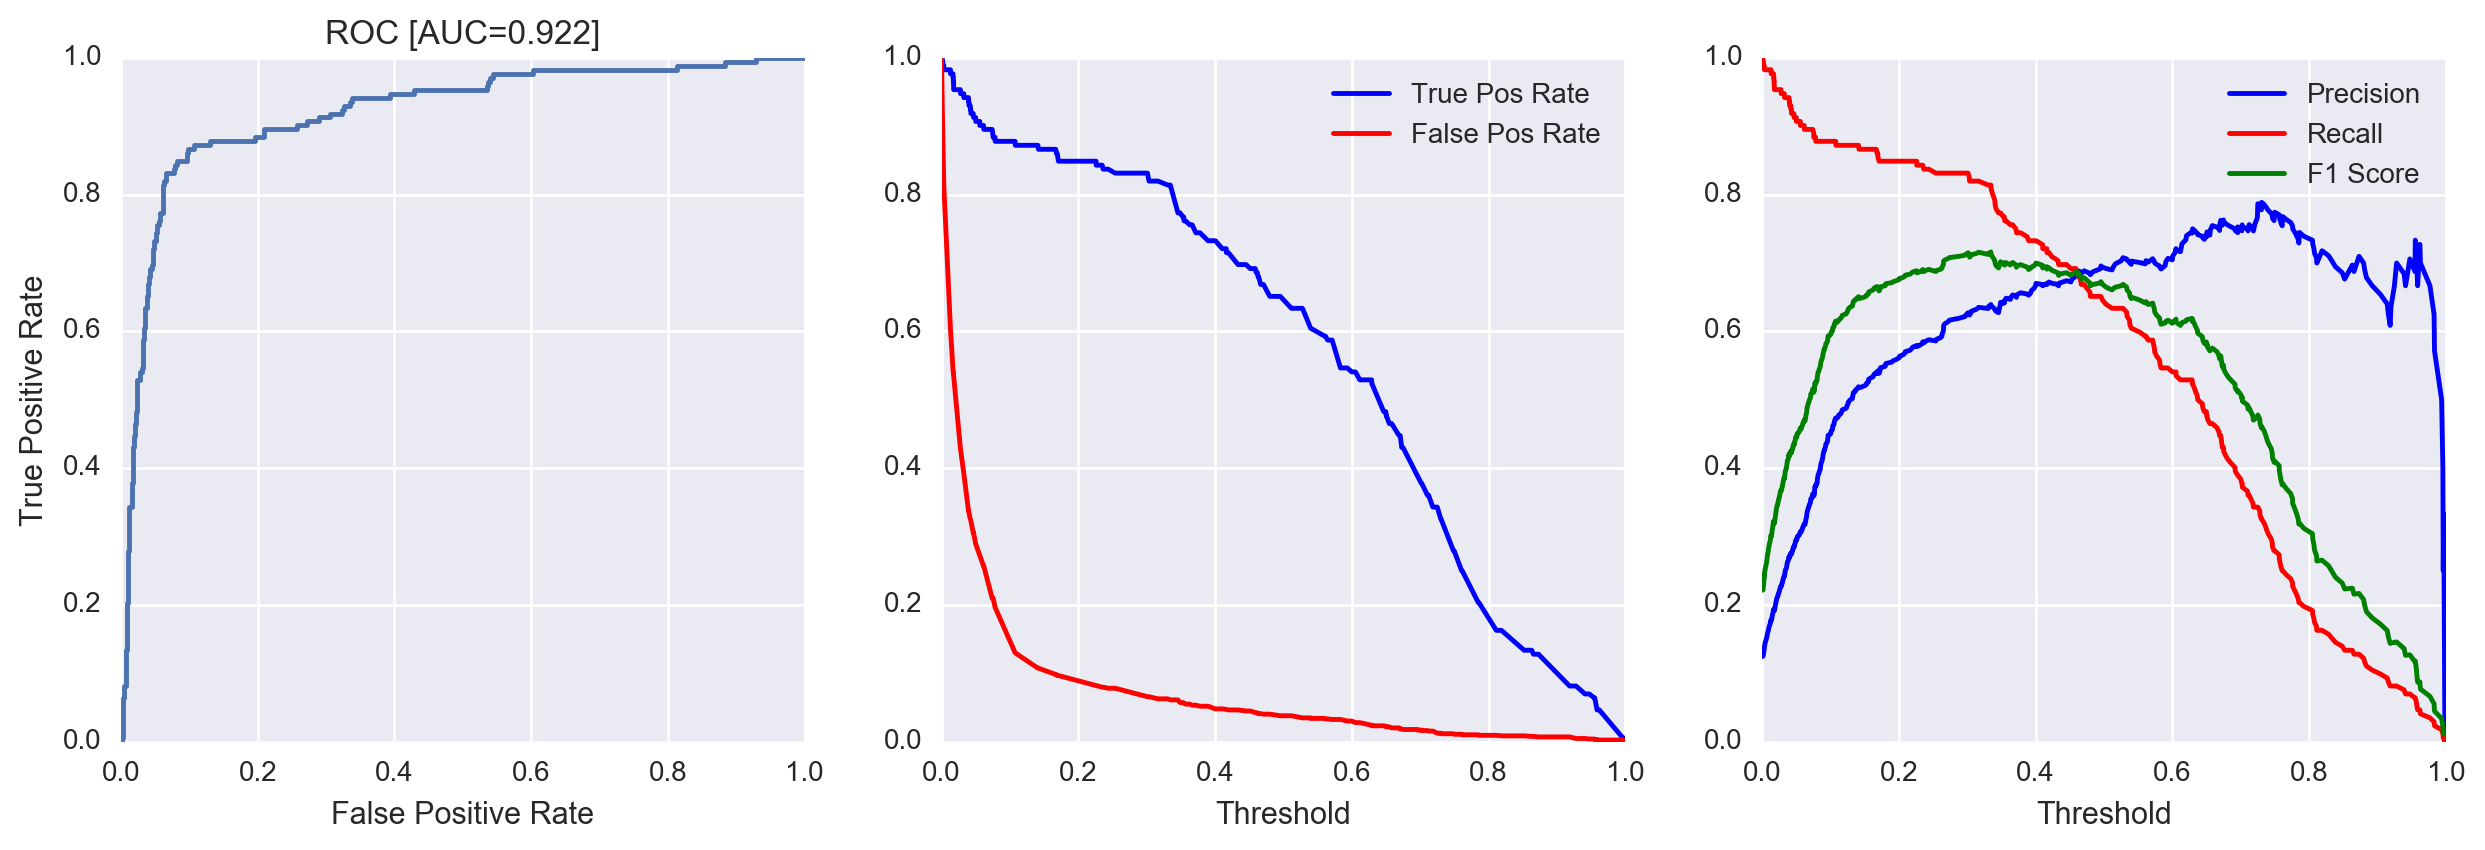

In [29]:
col = 'disabling_condition'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


disabling_condition = 0

Dropping these columns due to fewer than 70 people having this:
 ['chronic_homeless', 'housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_hospitalpsych', 'living_situation_before_program_entry_owned', 'project_type_code_permanentsupportivehousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'noncash_benefit_publichousing', 'health_insurance_pirvate', 'health_insurance_employer', 'disability_type_hivaids', 'disability_type_alcoholdrug', 'disability_type_developmental', 'disability_type_physical', 'disability_type_chronichealth', 'disability_type_alcohol', 'disability_type_drug']

train (4639, 58)
test (2286, 58)

disabling_condition = 0


/Users/mattmollison/miniconda3/envs/py3/lib/python3.5/site-packages/sklearn/linear_model/base.py:352: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)



AUC: 0.90639
Precision: 0.6154
Recall: 0.3547
F1 score: 0.4500

Confusion Matrix
Prediction     0    1   All
Truth                      
0           2038   45  2083
1            131   72   203
All         2169  117  2286

Percent of outcomes classified
Prediction         0          1
Truth                          
0           93.96035  38.461538
1            6.03965  61.538462

As feature increases, more likely to be in positive class:
                                                       coef      odds
health_insurance_stateadult                        2.064232  7.879247
health_insurance_statechild                        1.872639  6.505444
living_situation_before_program_entry_rentalother  1.406342  4.080999
project_type_code_rapidrehousing                   1.392951  4.026714
health_insurance_veteranadmin                      1.271840  3.567410
project_type_code_homelessnessprevention           1.227377  3.412266
head_of_household                                  1.084442  2.95778

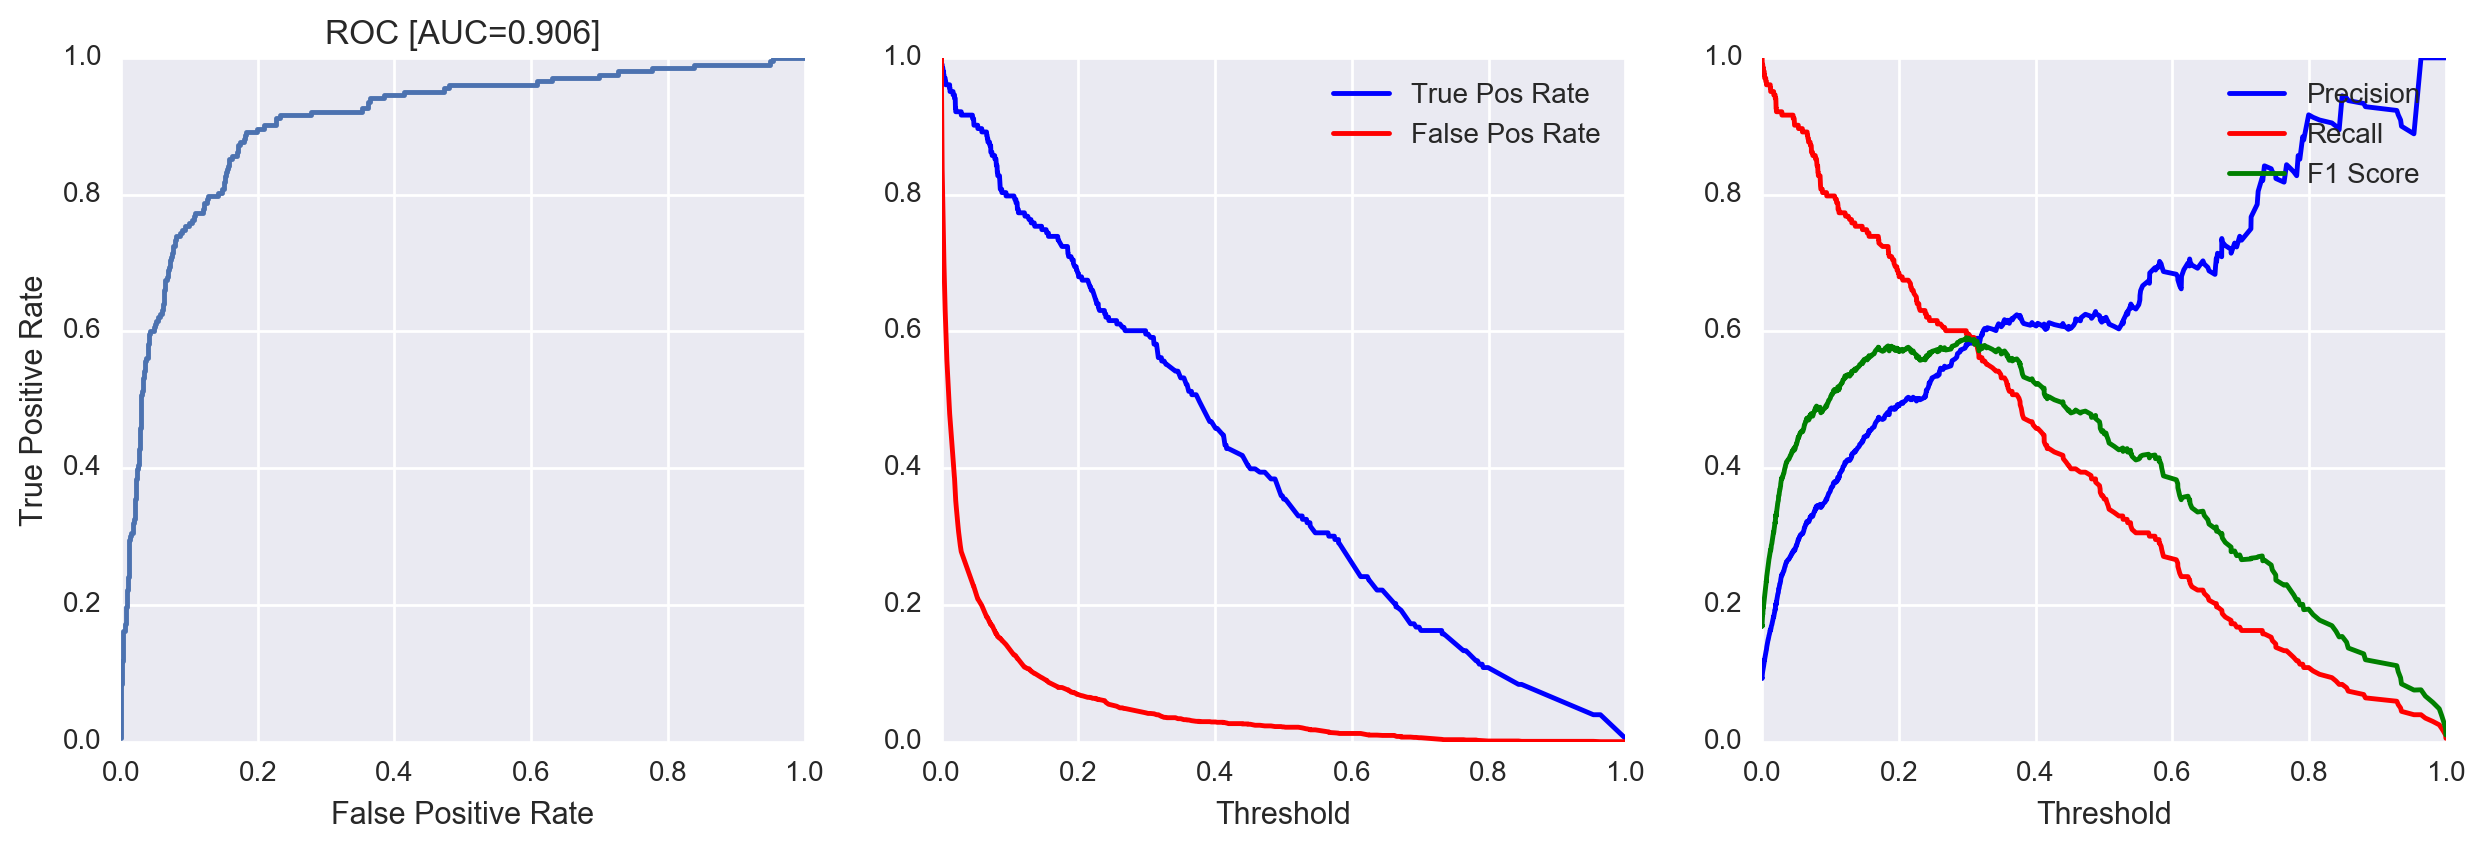

In [30]:
col = 'disabling_condition'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


domestic_violence_victim = 1

Dropping these columns due to fewer than 21 people having this:
 ['living_situation_before_program_entry_owned', 'noncash_benefit_tanfother', 'health_insurance_pirvate', 'disability_type_hivaids']

train (1394, 73)
test (687, 73)

domestic_violence_victim = 1

AUC: 0.88214
Precision: 0.5556
Recall: 0.3333
F1 score: 0.4167

Confusion Matrix
Prediction    0   1  All
Truth                   
0           649   8  657
1            20  10   30
All         669  18  687

Percent of outcomes classified
Prediction          0          1
Truth                           
0           97.010463  44.444444
1            2.989537  55.555556

As feature increases, more likely to be in positive class:
                                                        coef      odds
project_type_code_rapidrehousing                    1.615056  5.028172
health_insurance_veteranadmin                       1.434913  4.199279
health_insurance_stateadult                         1.191155  3.2

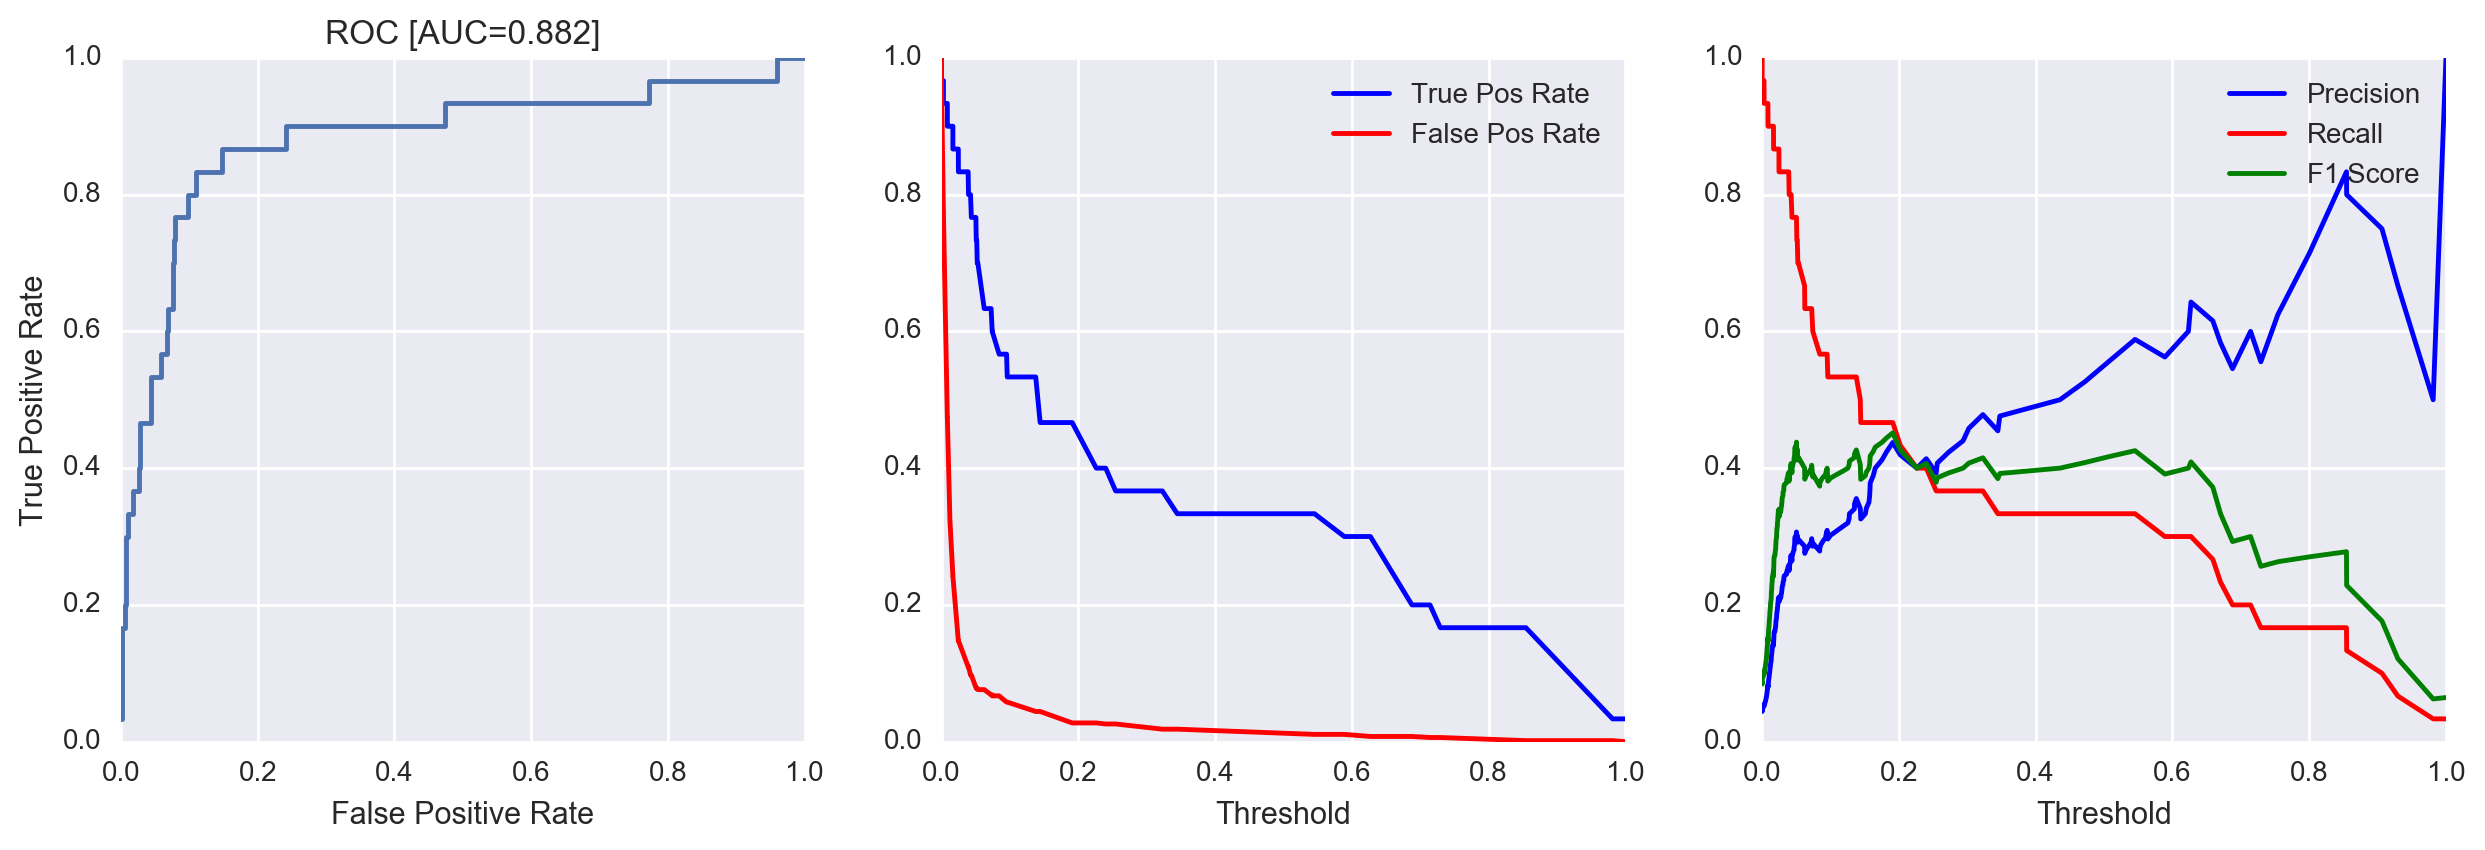

In [31]:
col = 'domestic_violence_victim'
cols_to_drop = [col]

val_to_keep = 1

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)


domestic_violence_victim = 0

Dropping these columns due to fewer than 93 people having this:
 ['housing_status_project_start_cat3homelessfedstatutes', 'living_situation_before_program_entry_foster', 'living_situation_before_program_entry_permanenthousing', 'noncash_benefit_tanfother', 'noncash_benefit_tanfchildcare', 'noncash_benefit_tanftransportation', 'health_insurance_pirvate', 'health_insurance_employer']

train (6218, 69)
test (3063, 69)

domestic_violence_victim = 0

AUC: 0.91776
Precision: 0.6930
Recall: 0.4606
F1 score: 0.5534

Confusion Matrix
Prediction     0    1   All
Truth                      
0           2650   70  2720
1            185  158   343
All         2835  228  3063

Percent of outcomes classified
Prediction          0          1
Truth                           
0           93.474427  30.701754
1            6.525573  69.298246

As feature increases, more likely to be in positive class:
                                                       coef      odds
heal

/Users/mattmollison/src/c4sf/datasci-sf-homeless-project/notebooks/../src/data/classify_utils.py:84: RuntimeWarning: invalid value encountered in true_divide
  f1_curve = 2*((precision_curve * recall_curve) / (precision_curve + recall_curve))


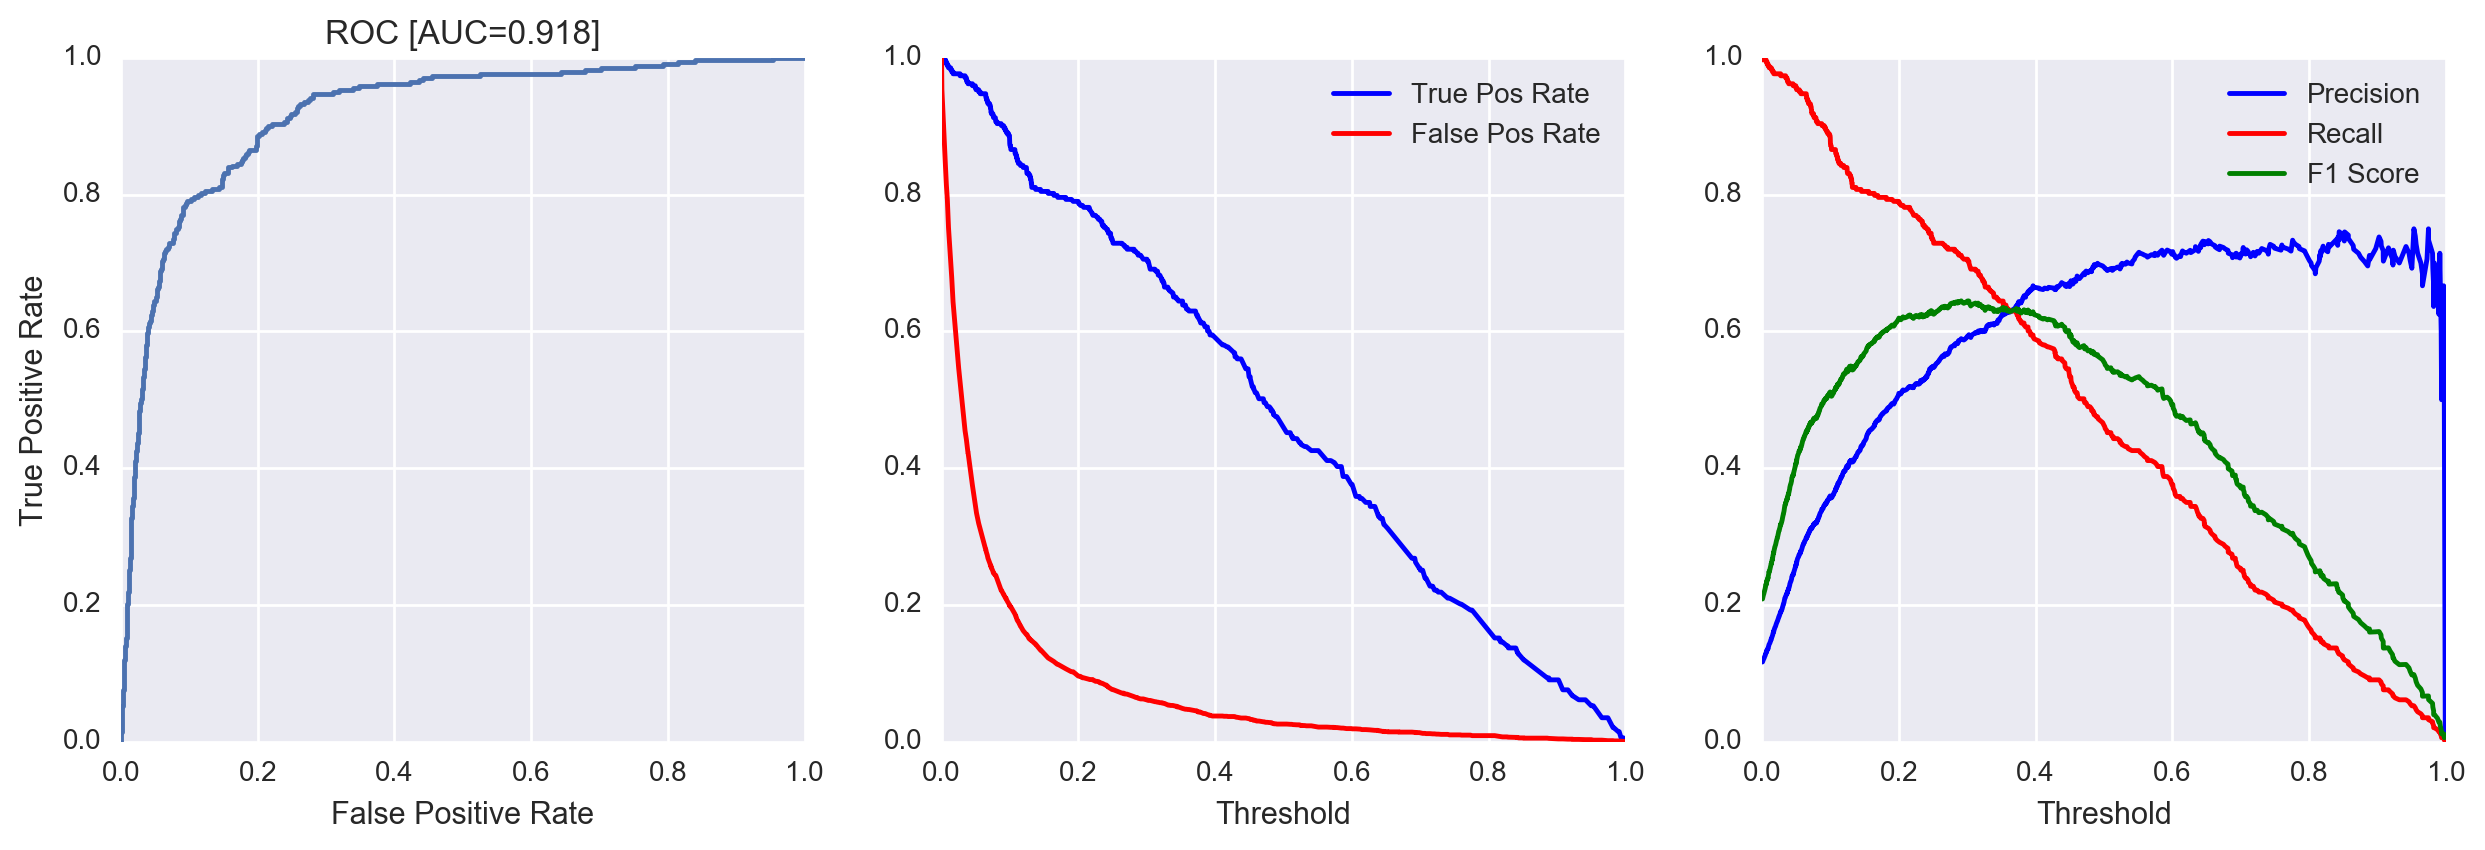

In [32]:
col = 'domestic_violence_victim'
cols_to_drop = [col]

val_to_keep = 0

results, myLR, y = predict_group(df_features_num, col, cols_to_drop, val_to_keep=val_to_keep)

coef_df, odds_df, stat_df = collect_results(results, col, coef_df, odds_df, stat_df, y, val_to_keep)

In [33]:
new_idx = odds_df.index.tolist()
new_idx = ['project_' + x.split('_')[-1] if x.split('_')[0] == 'project' else x for x in new_idx]
new_idx = ['living_' + x.split('_')[-1] if x.split('_')[0] == 'living' else x for x in new_idx]
new_idx = ['status_' + x.split('_')[-1] if x.split('_')[0] == 'housing' else x for x in new_idx]
new_idx = ['noncash_' + x.split('_')[-1] if x.split('_')[0] == 'noncash' else x for x in new_idx]
new_idx = ['health_' + x.split('_')[-1] if x.split('_')[0] == 'health' else x for x in new_idx]
new_idx = ['disable_' + x.split('_')[-1] if x.split('_')[0] == 'disability' else x for x in new_idx]

odds_df.index = new_idx
odds_df = odds_df.dropna(how='all')

coef_df.index = new_idx
coef_df = coef_df.dropna(how='all')

In [47]:
stat_df.head()

n  n_perm_housing  prop_perm_housing
gender_female     4848.0           363.0           0.074876
gender_male       6503.0           785.0           0.120714
veteran_status_1  2191.0           669.0           0.305340
veteran_status_0  9171.0           479.0           0.052230
ethnicity_latino  5207.0           419.0           0.080469

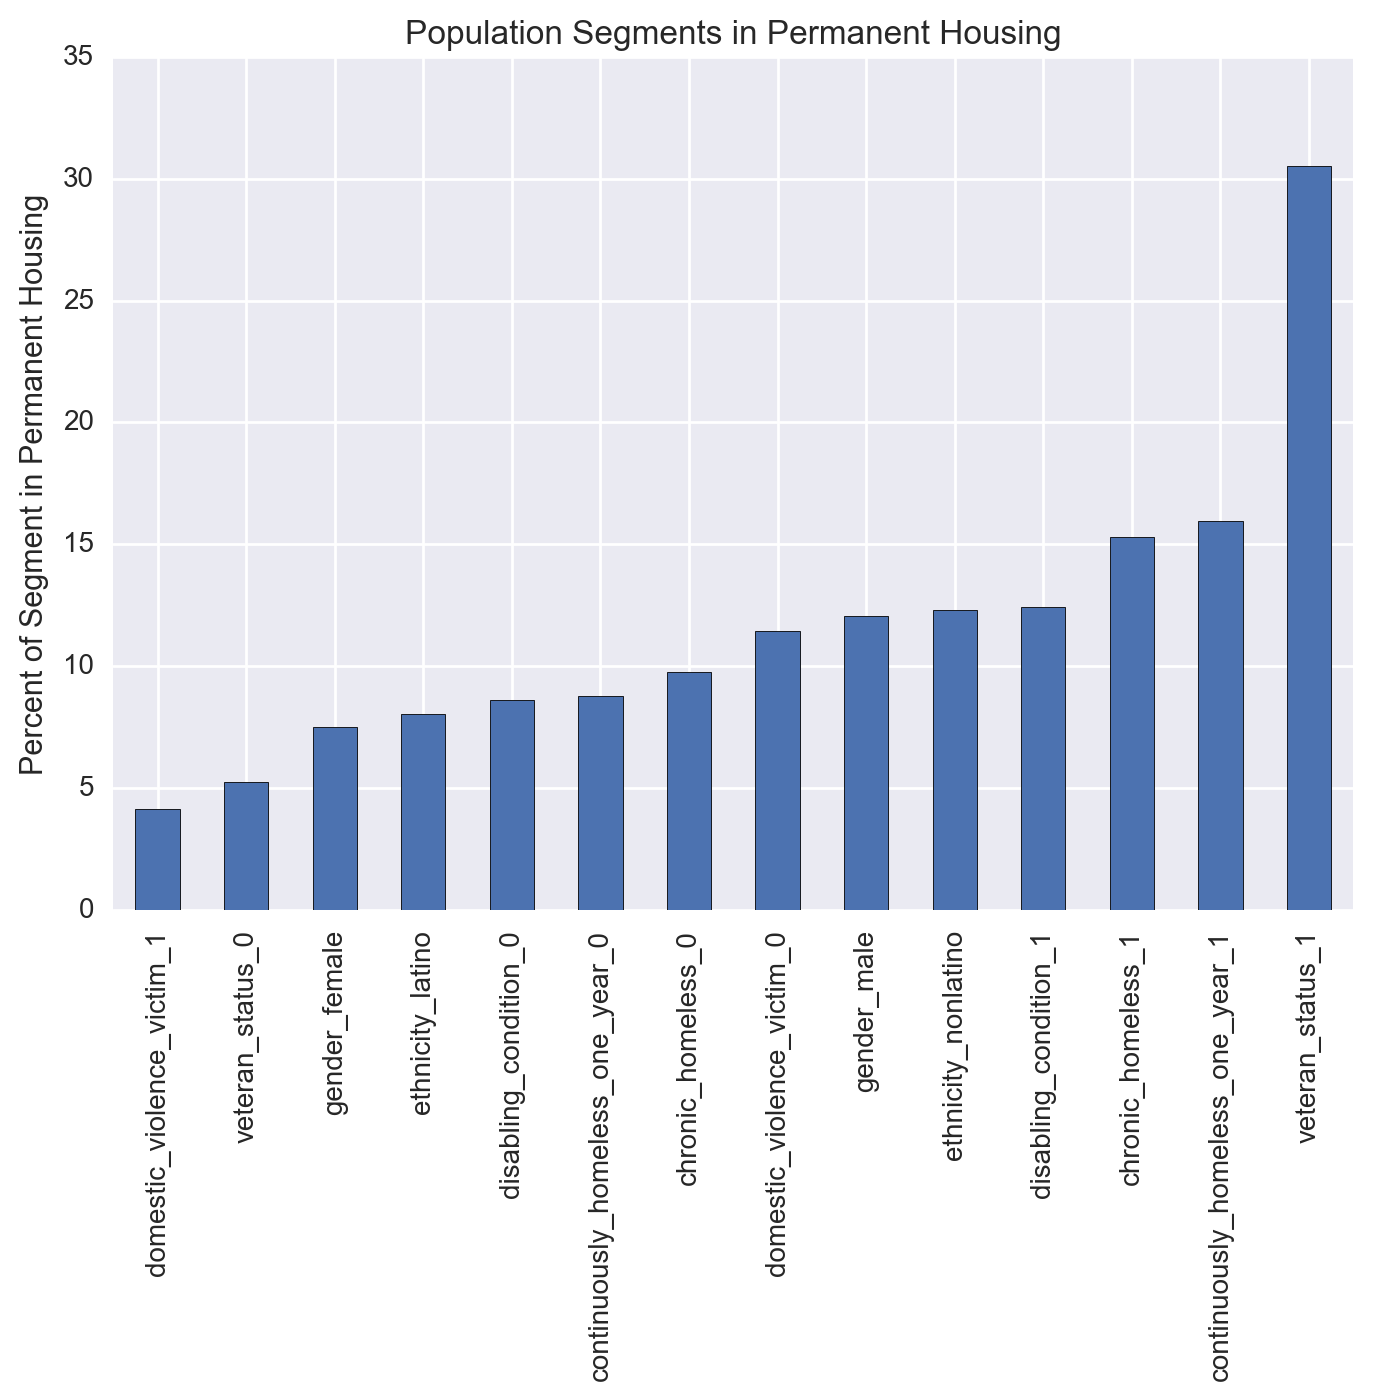

In [48]:
fig, ax = plt.subplots()
stat_df['prop_perm_housing'].sort_values().mul(100).plot(ax=ax, kind='bar');
ax.set_ylabel('Percent of Segment in Permanent Housing');
ax.set_title('Population Segments in Permanent Housing');

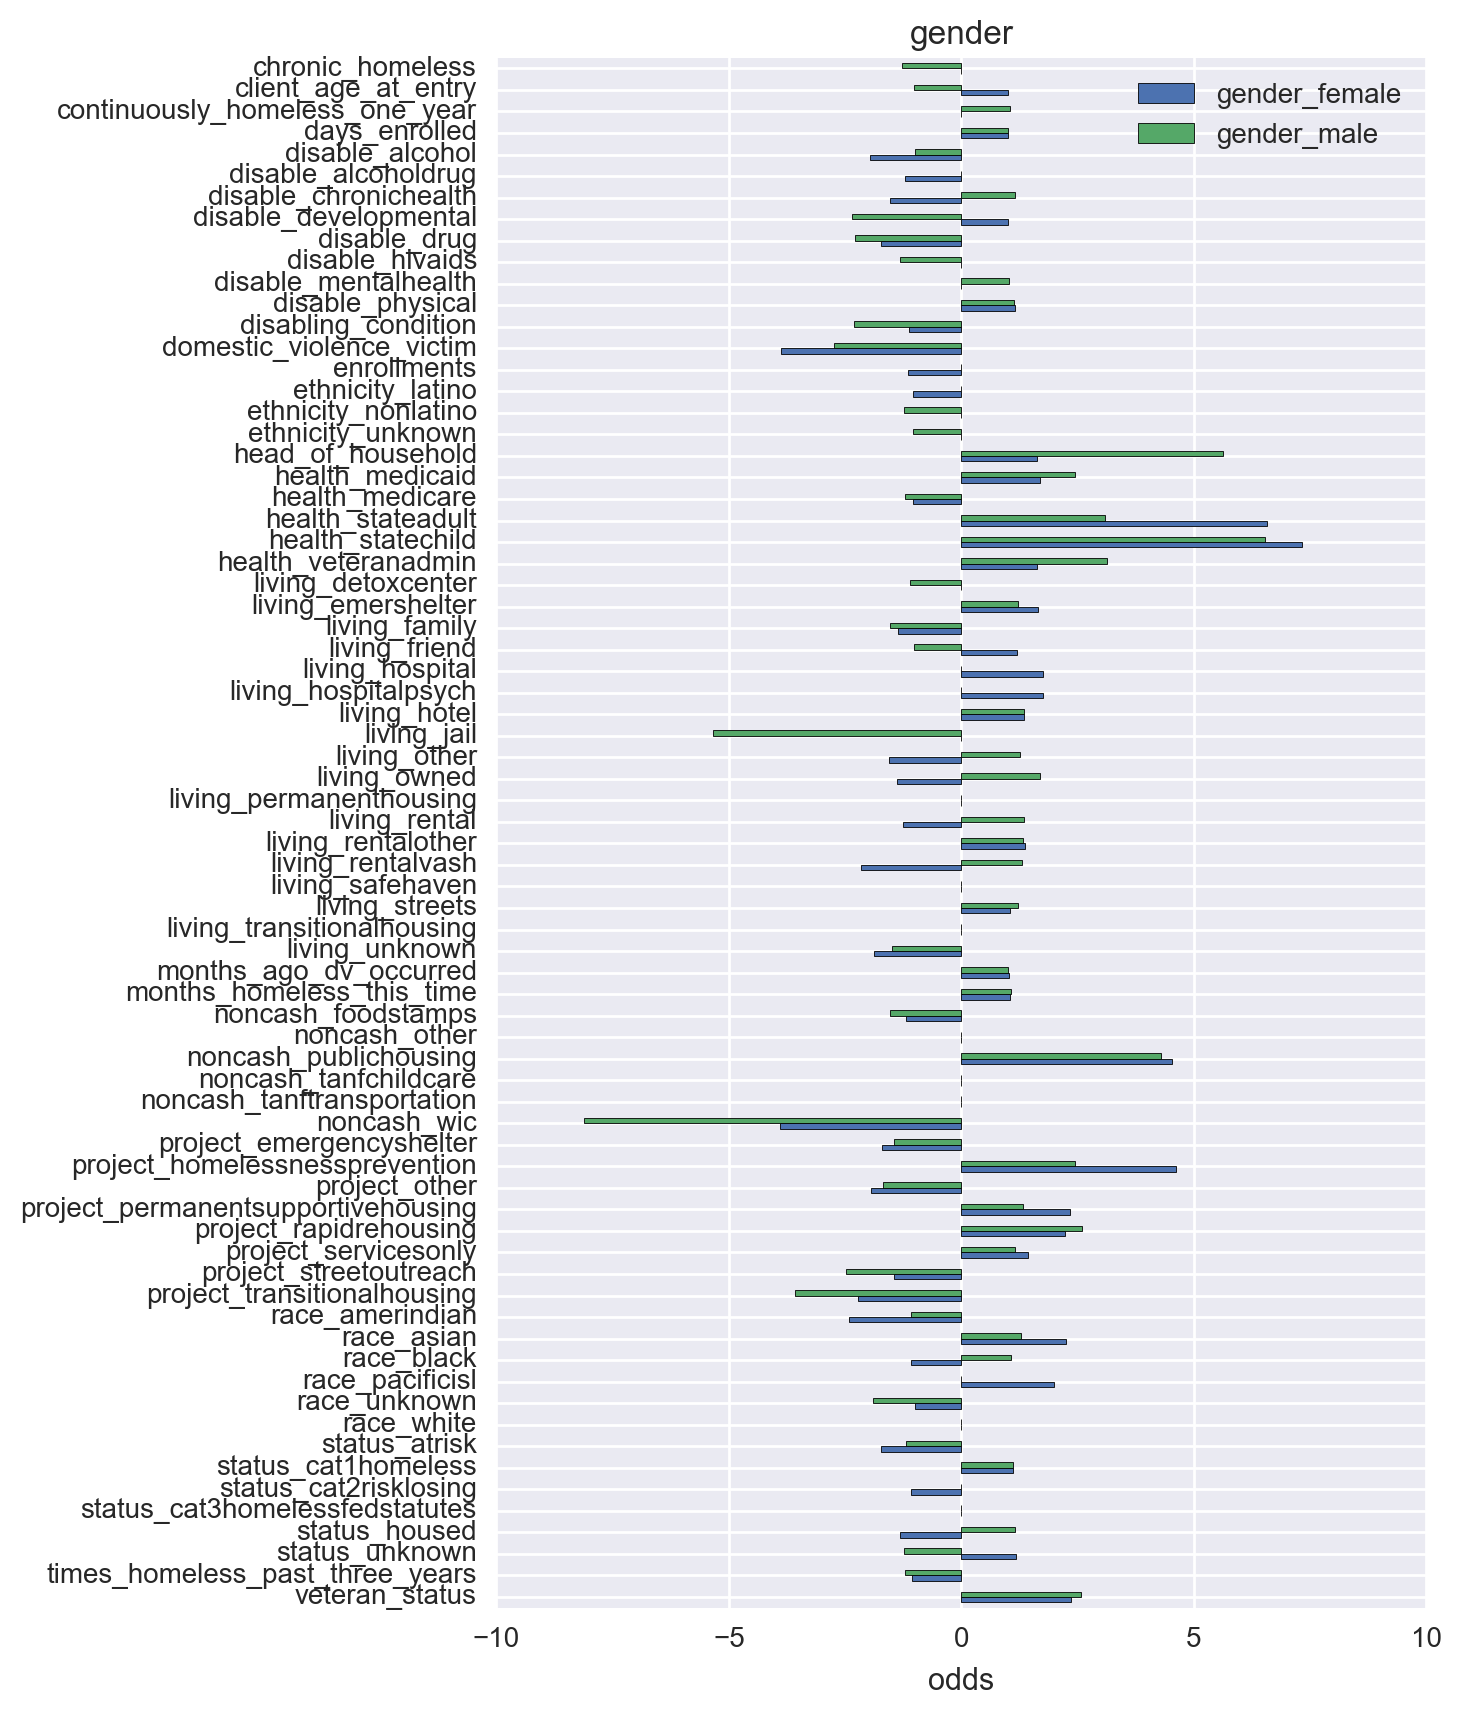

In [34]:
these_cols = ['gender_female', 'gender_male']
# these_cols = ['ethnicity_latino', 'ethnicity_nonlatino']
# these_cols = ['veteran_status_1', 'veteran_status_0']
# these_cols = ['chronic_homeless_1', 'chronic_homeless_0']
# these_cols = ['continuously_homeless_one_year_1', 'continuously_homeless_one_year_0']
# these_cols = ['disabling_condition_1', 'disabling_condition_0']
# these_cols = ['domestic_violence_victim_1', 'domestic_violence_victim_0']

group_name = os.path.commonprefix(these_cols)[:-1]

xlim = (-10, 10)

# ncols = 1
# if ncols > len(these_cols):
#     ncols = len(these_cols)
# nrows = int(np.ceil(len(these_cols) / ncols))

fig, ax = plt.subplots(figsize=(6, 10))

odds_df[these_cols].dropna(how='all').sort_index(ascending=False).plot(ax=ax, kind='barh');
ax.set_title(group_name);
ax.set_xlabel('odds');
ax.set_xlim(xlim);

### TODO: color code categories

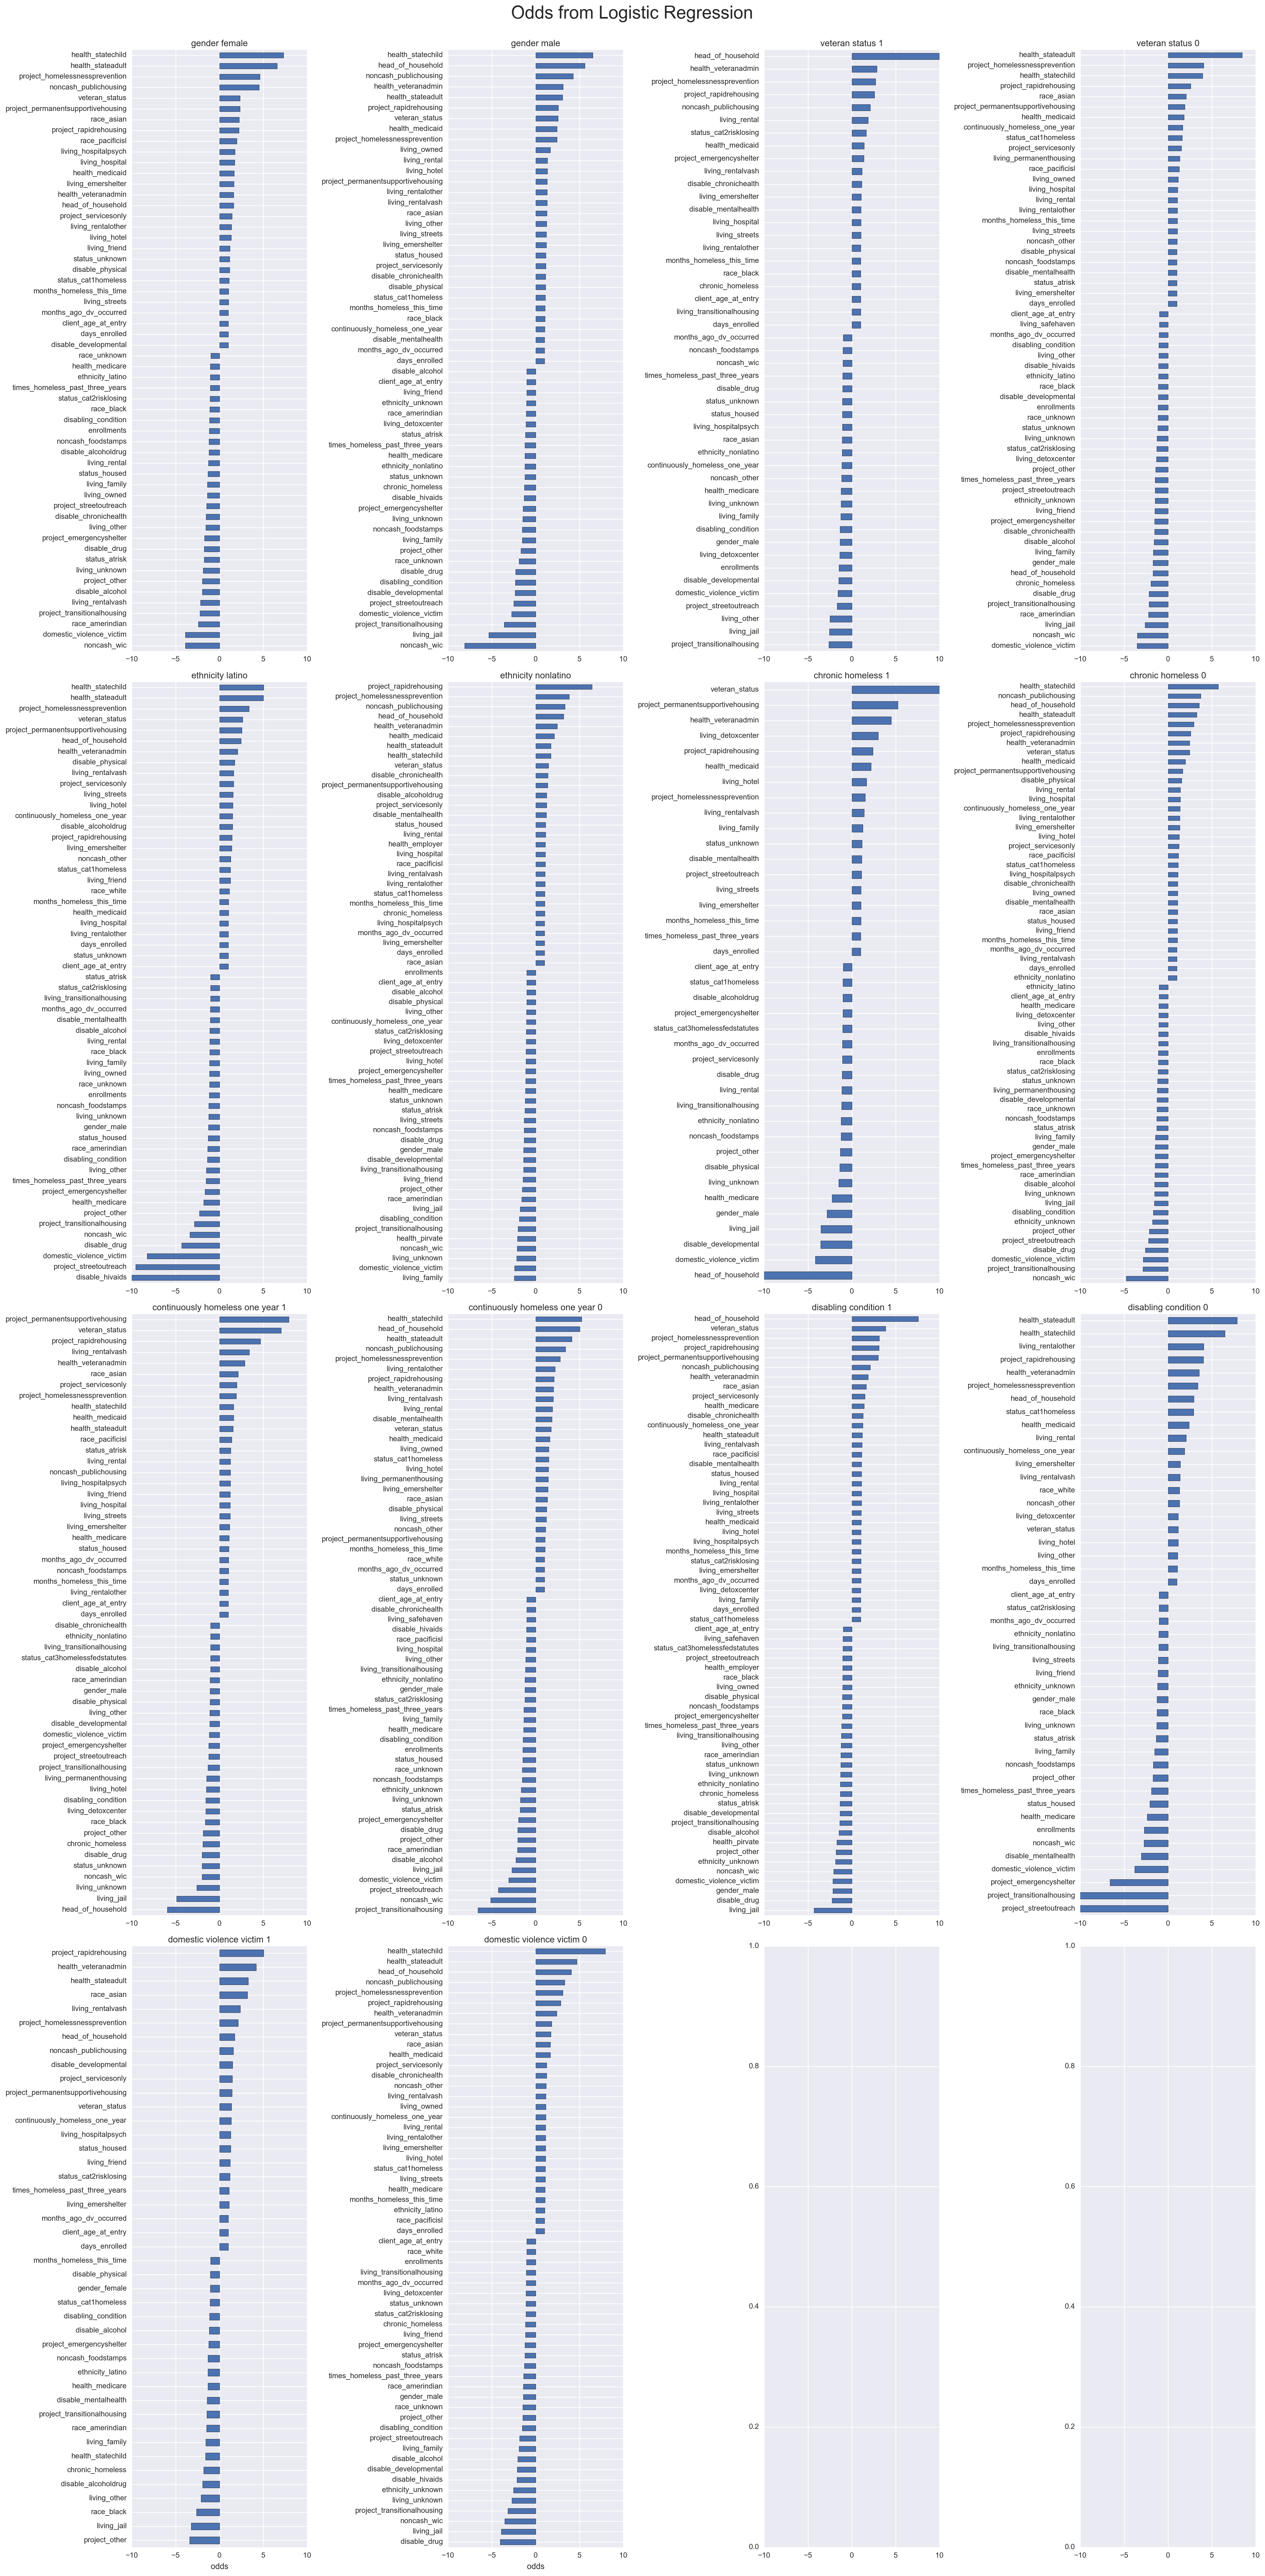

In [60]:
these_cols = odds_df.columns

ncols = 4

xlim = (-10, 10)

if ncols > len(these_cols):
    ncols = len(these_cols)
nrows = int(np.ceil(len(these_cols) / ncols))

fig, (axes) = plt.subplots(nrows=nrows, ncols=ncols,
                           sharex=True, sharey=False,
                           figsize=(6*ncols, 12*nrows))

for col, ax in zip(these_cols, axes.ravel()):
    odds_df.loc[(odds_df[col] != 0) & ((odds_df[col] < -1.0) | (odds_df[col] > 1.0)), col].dropna(how='all').sort_values(ascending=True).plot(ax=ax, kind='barh');
    #odds_df[col].dropna(how='all').sort_values(ascending=True).plot(ax=ax, kind='barh');
    ax.set_title(col.replace('_', ' '));
    ax.set_xlabel('odds');
    ax.set_xlim(xlim);

# turn on the x and y tick labels even when sharing axes
[([tk.set_visible(True) for tk in ax.get_xticklabels()],
  [tk.set_visible(True) for tk in ax.get_yticklabels()]) for ax in axes.flatten()];

fig.tight_layout();

fig.suptitle('Odds from Logistic Regression', fontsize=24, y=1.01);
# fig.subplots_adjust(top=0.85);

In [36]:
# from sklearn.model_selection import KFold

# kf = KFold(n_splits=2, shuffle=True)

# outcome = 'in_permanent_housing'
# outcome_related = ['in_permanent_housing', 'days_to_residential_move_in', 'times_in_permanent_housing']
# y = df_model_num[outcome].values
# X = df_model_num.drop(outcome_related, axis=1)

# # X = X.apply(lambda x: x.fillna(x.median()),axis=0) 

# for train_index, test_index in kf.split(X):
#     X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
#     y_train, y_test = y[train_index], y[test_index]

# print(X_train.shape)
# print(X_test.shape)

In [37]:
# results, myAuc, precision, recall, f1, myLR = cu.classify(X_train, X_test,
#                                                           y_train, y_test,
#                                                           'lr',
#                                                           print_n_features=20);

In [38]:
# results, myAuc, precision, recall, f1, myRF = cu.classify(X_train, X_test,
#                                                           y_train, y_test,
#                                                           'rf',
#                                                           n_estimators=10,
#                                                           min_samples_leaf=20,
#                                                           print_n_features=30);

In [39]:
# from sklearn import tree

# for i, tr in enumerate(myRF.estimators_):
#     tree.export_graphviz(tr, feature_names=X_train.columns, filled=True, rounded=True,
#                          class_names=['no', 'yes'],
#                          out_file='/Users/mattmollison/Desktop/trees/tree_{}.dot'.format(i))

In [40]:
# results = pd.DataFrame(myRF.feature_importances_, index=X_train.columns, columns=['importance'])
# results['std'] = np.std([tree.feature_importances_ for tree in myRF.estimators_], axis=0)

# results = results.sort_values(['importance'], ascending=False)

# results = results.iloc[:20, :]

# fig, ax = plt.subplots()
# results['importance'].iloc[::-1].plot(kind='barh', xerr=results['std'].iloc[::-1], ax=ax);

# ax.set(title='Random Forest feature importance',
#       );